In [1]:
from matplotlib import pyplot as plt
import numpy as np
import random
import csv
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

from solar_module import SolarModule, generate_shading, generate_gaussian
from solar_cell import all_series_bypass, SP_interconnection, TCT_interconnection
from string_to_embedding import string_to_embedding, super_to_embedding

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/Users/mlima/opt/anaconda3/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [2]:
class Model(nn.Module):
    def __init__(self, imgchannels=1, fdim=8, zdim=32, mdim=4096, kern=3, imgshape=(3,3), stride=1, pad=1):
        
        super(Model, self).__init__()
        
        # First 2D convolutional layer, taking in 1 input channel (image),
        # outputting 8 convolutional features, with a square kernel size of 2
        self.conv1 = nn.Conv2d(imgchannels, fdim, kern, stride, pad) # (1, 8, 3, 1)

        # Second 2D convolutional layer, taking in the 8 input layers,
        # outputting 32 convolutional features, with a square kernel size of 2
        self.conv2 = nn.Conv2d(fdim, zdim, kern, stride, pad) # (8, 32, 3, 1, 1)

        # Designed to ensure that adjacent pixels are either all 0s or all active
        # with an input probability
        #self.dropout1 = nn.Dropout2d(0.25)
        #self.dropout2 = nn.Dropout2d(0.5)
        
        ldim = zdim*imgshape[0]*imgshape[1]
        self.ldim = ldim

        # First fully connected layer
        self.fc1 = nn.Linear(ldim, mdim) #add a middle linear layer, with size 
        self.fc3 = nn.Linear(mdim, mdim)
        outdim = (imgshape[0]*imgshape[1])**2*3+imgshape[0]*imgshape[1]*2
        #outdim = (imgshape[0]*imgshape[1])**2*3
        self.fc2 = nn.Linear(mdim, outdim)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        #print(x.shape)
        
        x = self.conv2(x)
        x = F.relu(x)
        #print(x.shape)
        
        #x = self.dropout1(x)
        x = x.view(-1, self.ldim)
        #print(x.shape)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        #print(x.shape)
        #x = self.dropout2(x)
        x = self.fc2(x)
        #print(x.shape)
        
        x = F.relu(x)
        #x = x.bool()
        
        return x

model = Model(imgshape=(10, 6)).to(device)
print(model)
print(device)
for param in model.parameters():
  print(param.data)

Model(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1920, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=10920, bias=True)
)
cpu
tensor([[[[-0.2093,  0.0917,  0.2255],
          [ 0.2769, -0.3014,  0.1272],
          [-0.2838,  0.2648,  0.2799]]],


        [[[-0.2415,  0.0338, -0.0929],
          [-0.0827,  0.0332,  0.2010],
          [-0.1669, -0.0725, -0.1023]]],


        [[[-0.2160, -0.0287,  0.2836],
          [ 0.2077, -0.0460,  0.2996],
          [-0.2928, -0.2050,  0.2617]]],


        [[[-0.1924, -0.0864,  0.2068],
          [ 0.2096, -0.0355, -0.2173],
          [-0.0973, -0.0084,  0.2969]]],


        [[[-0.2483, -0.2814,  0.1119],
          [ 0.0855, -0.0231,  0.2798],
          [ 0.2526, -0.3141,  0.0264]]],


        [[[-0.0967,  0.1994, -0.0196],

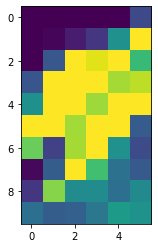

In [3]:
rand_smap = generate_gaussian(10, 10, 6)
plt.imshow(rand_smap)

In [4]:
rand_smap = torch.Tensor(np.expand_dims(rand_smap,0))
print(rand_smap)
print(rand_smap.shape)

tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  2.2093],
         [ 0.0000,  0.1744,  0.8140,  1.5698,  5.0581, 10.0000],
         [ 0.0000,  2.7326, 10.0000,  9.5349, 10.0000,  6.7442],
         [ 2.6744, 10.0000, 10.0000, 10.0000,  8.6628,  9.0116],
         [ 5.0000, 10.0000, 10.0000,  8.5465, 10.0000, 10.0000],
         [10.0000, 10.0000,  8.6047, 10.0000, 10.0000,  2.9070],
         [ 7.7326,  1.9767,  8.6628, 10.0000,  5.0581,  2.3256],
         [ 0.2326,  2.9651, 10.0000,  6.9767,  3.7791,  2.8488],
         [ 1.5698,  8.1977,  4.8256,  4.8256,  3.6628,  4.7674],
         [ 3.6628,  2.9651,  3.0814,  3.9535,  5.4651,  5.1163]]])
torch.Size([1, 10, 6])


In [5]:
result = model(rand_smap)
print(result)
print(result.shape)

tensor([[0.0246, 0.0000, 0.0000,  ..., 0.0786, 0.0555, 0.0000]],
       grad_fn=<ReluBackward0>)
torch.Size([1, 10920])


[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


(10800,)
(120,)
(0, 0, 0, 1, 0, 60, 0.0)
0.0


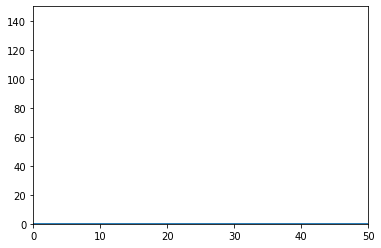

In [7]:
## convert output to embedding using SolarModule object
model.eval()
with torch.no_grad():
    out_data = model(rand_smap)
    #out_data = out_data.type(torch.bool)
    #print(out_data)
    
    out_data = out_data.reshape(10920).cpu().numpy()
    
embedding, terminal_array = out_data[:10800], out_data[10800:]
print(embedding.shape)
print(terminal_array.shape)
embedding = embedding.reshape(10, 6, 10, 6, 3)
terminal_array = terminal_array.reshape(10, 6, 2)
moduleobj = SolarModule(10,6)
moduleobj.embedding = embedding
moduleobj.terminal_array = terminal_array

#Fix (0,0) and (2,2) to be ground and positive
#moduleobj.connect_to_ground(0,0)
#moduleobj.connect_to_pos(9,5)

print(moduleobj.filter_embedding())
moduleobj.make_netlist()
moduleobj.simulate()
print(moduleobj.MPP)
moduleobj.plot_netlist()

Text(0.5, 1.0, 'Shading Map 4777')

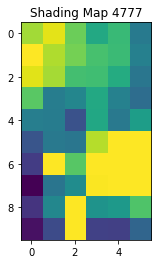

In [8]:
"""Load in Dataset (training_data.csv)"""
read_in = pd.read_csv("shading_series.csv")
def convert_to_array(string):
    a = np.matrix(string).reshape(10, 6)
    a = np.array(a)
    return a
shading_series = [convert_to_array(s) for s in read_in['Shading Maps']]
s = random.randint(0, 10000)
plt.imshow(shading_series[s])
plt.title("Shading Map " + str(s))

In [9]:
read_in = pd.read_csv("embedding_series.csv", header=0, names=['SuperString'], usecols=[1])
configurations = [x for x in read_in['SuperString']]


In [10]:
""" Create dataset data frame """
df = pd.read_csv("training_data.csv",dtype={'MPP':float, 'VMP':float, 'IMP':float, 'VOC':float, 'ISC':float, 'FF':float})
print(df)

         Shading Map #  SuperString #         MPP    VMP         IMP    VOC  \
0                    0              0  227.435930   0.67  339.456612   0.75   
1                    0              1   14.058677   3.59    3.916066   3.78   
2                    0              2  179.316049   0.67  267.635894   0.76   
3                    0              3  185.737293   0.67  277.219840   0.76   
4                    0              4  143.931344   0.67  214.822901   0.76   
...                ...            ...         ...    ...         ...    ...   
3706427           3813            834   30.880000   3.41    9.060000   3.84   
3706428           3813            835    0.040000  19.00    0.000000  37.99   
3706429           3813            836    0.040000  18.99    0.000000  37.98   
3706430           3813            837   20.290000   2.08    9.760000   2.30   
3706431           3813            838    0.040000  19.74    0.000000  39.48   

                ISC        FF  
0        353.587870

In [11]:
"""Create Normalised Column"""
normalised = []
for idx, x in enumerate(df['Shading Map #']):
    shading_map = shading_series[x].flatten()
    mpp = df.iloc[idx, 2]
    normalised.append(mpp/sum(shading_map))

In [148]:
print(max(normalised))

0.6449678511000733


In [12]:
df['Normalised MPP'] = normalised
print(df)

         Shading Map #  SuperString #         MPP    VMP         IMP    VOC  \
0                    0              0  227.435930   0.67  339.456612   0.75   
1                    0              1   14.058677   3.59    3.916066   3.78   
2                    0              2  179.316049   0.67  267.635894   0.76   
3                    0              3  185.737293   0.67  277.219840   0.76   
4                    0              4  143.931344   0.67  214.822901   0.76   
...                ...            ...         ...    ...         ...    ...   
3706427           3813            834   30.880000   3.41    9.060000   3.84   
3706428           3813            835    0.040000  19.00    0.000000  37.99   
3706429           3813            836    0.040000  18.99    0.000000  37.98   
3706430           3813            837   20.290000   2.08    9.760000   2.30   
3706431           3813            838    0.040000  19.74    0.000000  39.48   

                ISC        FF  Normalised MPP  
0  

In [17]:
vmp_filtered = df.loc[df['VMP']>3]
vmp_filtered = vmp_filtered.loc[vmp_filtered['IMP']>0.1]
vmp_filtered = vmp_filtered.loc[df['Normalised MPP']>0.1]
print(vmp_filtered)


         Shading Map #  SuperString #        MPP    VMP        IMP    VOC  \
29                   0             29  51.704728  35.80   1.444266  36.39   
87                   0             87  55.378736  40.17   1.378609  40.86   
94                   0             94  40.152784  20.74   1.936007  21.24   
96                   0             96  54.426668  39.48   1.378588  40.16   
138                  0            139  41.021058  24.51   1.673646  25.02   
...                ...            ...        ...    ...        ...    ...   
3706396           3813            801  61.980000   5.04  12.300000   5.46   
3706410           3813            816  70.490000  10.30   6.840000  10.67   
3706421           3813            827  65.080000  26.12   2.490000  26.72   
3706422           3813            828  46.790000  13.34   3.510000  13.80   
3706425           3813            832  92.020000   7.99  11.520000   8.61   

               ISC        FF  Normalised MPP  
29        1.448993  0.980577

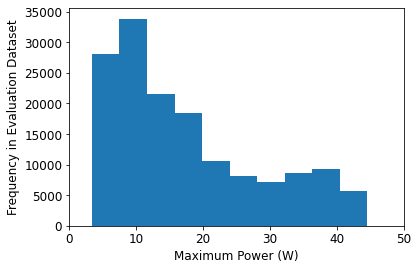

In [18]:
fig, ax = plt.subplots()
ax.hist(vmp_filtered['VMP'], color='C0')
#ax.hist(p_list, color='C1')
ax.set_xlabel('Maximum Power (W)',fontsize='large')
ax.set_ylabel('Frequency in Evaluation Dataset',fontsize='large')
ax.tick_params(axis='both', labelsize='large')
ax.set_xlim(0,50)
fig.savefig('histogram.png',dpi=300,bbox_inches="tight")

In [19]:
""" Create custom dataset """

class CustomDataset(Dataset):
    def __init__(self, df, rotate=None):
        self.df = df
        self.rotate = rotate # for rotation of shading maps?

    def __getitem__(self, index):
        shading_map = self.df.iloc[index, 0]
        shading_map = shading_series[shading_map]
        #print(shading_map)
        shading_map = torch.Tensor(shading_map)/10
        shading_map = shading_map.unsqueeze(0)
        
        x = self.df.iloc[index, 1]
        x = configurations[x]
        #print(x)
        x = super_to_embedding(10, 6, x) # superstring to boolean embedding
        embedding = x.embedding
        terminal_array = x.terminal_array
        embedding = embedding.flatten()
        terminal_array = terminal_array.flatten()
        
        label = np.append(embedding, terminal_array)
        label = torch.Tensor(label)
        
        power = self.df.iloc[index, -1]
        
        return shading_map, label, power 
        
    def __len__(self):
        return len(self.df['Shading Map #'])
dataset = CustomDataset(vmp_filtered)
print(dataset.__getitem__(2))
print(dataset.__getitem__(2)[0].shape, dataset.__getitem__(2)[1].shape)
print(len(dataset))


(tensor([[[0.5388, 0.4008, 0.1380, 0.0591, 0.0493, 0.0000],
         [0.9790, 0.8180, 0.3351, 0.2661, 0.2037, 0.1675],
         [1.0000, 1.0000, 0.8147, 0.6537, 0.4895, 0.3219],
         [0.9527, 1.0000, 1.0000, 1.0000, 0.8311, 0.6636],
         [0.5848, 1.0000, 1.0000, 0.9921, 1.0000, 1.0000],
         [0.3187, 1.0000, 1.0000, 0.7917, 1.0000, 1.0000],
         [0.8081, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [0.4665, 0.4731, 0.4304, 0.6833, 1.0000, 1.0000],
         [0.7753, 0.5322, 0.1938, 0.4205, 0.6439, 0.6110],
         [0.4304, 0.2661, 0.1445, 0.5519, 0.7096, 0.3942]]]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), 0.10062161276000274)
torch.Size([1, 10, 6]) torch.Size([10920])
151280


In [83]:
""" Initialize Hyperparameters """
#10,000 iterations, batching of 32

#1e-3 learning rate

# vary each training parameter individually, run multiple experiments. Checkpoint each model, filename w/ parameters

batch_size = 32 # 32-64 is advisable
learning_rate = 1e-3 # sensitivity of gradient descent
num_epochs = 1 # iterations over entire dataset 


4727
torch.Size([10920])


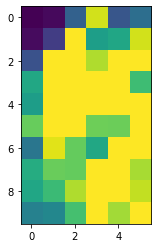

In [84]:
""" Dataloader """
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
print(len(train_dataloader))
x, y, p = next(iter(train_dataloader))
img = x[0].squeeze()
embedding = y[0].squeeze()
plt.imshow(img)
print(embedding.shape)

In [204]:
model = Model(imgshape=(10, 6)).to(device)
print(model)
print(device)

Model(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1920, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=10920, bias=True)
)
cpu


In [205]:
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [206]:
ratio_list = []
self_connections = []
conflicting_connections = []
loss_list = []

In [208]:
# iterate over epochs
entropy_loss = nn.MSELoss(reduction='none')
outfile = 'loss.csv'
with open(outfile, 'w', newline='') as f:
    writer = csv.writer(f)
    for epoch in range(num_epochs):

        # iterate over training dataset by batch
        for i, data in enumerate(train_dataloader, 0):

            shading_maps, embeddings, power = data
            shading_maps = shading_maps.to(device)
            result = model(shading_maps)
            """
            result = model(shading_maps)
            for j in range(batch_size):       
                result = model(shading_maps[j,...])[-1]
                label = embeddings[j]
                loss_ += entropy_loss(result.float(), label.float())
                break
            break
            """
            loss = torch.mean(entropy_loss(result, embeddings),axis=1)
            loss = torch.mean(loss*(1-power))
            
            average_ratio = 0
            self_c = 0
            conflicting_c = 0
            for j in range(0, batch_size):
                embedding = result[j]
                embedding = np.squeeze(embedding.detach())
                embedding, terminal_array = embedding[:10800], embedding[10800:]
                embedding = embedding.reshape(10, 6, 10, 6, 3)
                terminal_array = terminal_array.reshape(10, 6, 2)
                
                series_connections = torch.count_nonzero(embedding[...,0]) + torch.count_nonzero(embedding[...,1])
                parallel_connections = torch.count_nonzero(embedding[...,2])
                if parallel_connections == 0:
                    average_ratio += 0
                elif parallel_connections > 0:
                    average_ratio += (series_connections / parallel_connections)
                
                moduleobj = SolarModule(10, 6)
                moduleobj.embedding = np.array(embedding.numpy(), dtype=bool)
                moduleobj.terminal_array = np.array(terminal_array.numpy(), dtype=bool)
                filtering = moduleobj.filter_embedding()
                self_c += filtering[0]
                conflicting_c += filtering[1]
                
            average_ratio /= batch_size
            self_c /= batch_size
            conflicting_c /= batch_size
            ratio_list.append(float(average_ratio))
            self_connections.append(self_c)
            conflicting_connections.append(conflicting_c)
            
            loss_list.append(float(loss))
            
            writer.writerow([i, loss])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            print(i, ratio_list[i], self_connections[i], conflicting_connections[i], loss)
            
            if self_connections[i] < 1 and conflicting_connections[i] < 600:
                break
            
        print('Epoch {}: Loss {}'.format(epoch, loss))

# create validation/evaluation batch of 10 or so shading maps, calculate the power from that
# visualise embeddings or circuit diagram against shading map

# use embeddings generated by superstrings for supervised approach. 
# pre-train on training_data.csv
# binary cross entropy between model and training data

# sort training_data.csv by performance (power)
# train same model by binary cross entropy
# use entire dataset, then use higher performing subset, then a subset of that, etc. 
# label = embedding

0 1.9749536514282227 95.1875 1799.8125 tensor(0.0240, dtype=torch.float64, grad_fn=<MeanBackward0>)
1 1.235356092453003 27.84375 1322.3125 tensor(0.0196, dtype=torch.float64, grad_fn=<MeanBackward0>)
2 1.0536863803863525 7.90625 575.0625 tensor(0.0367, dtype=torch.float64, grad_fn=<MeanBackward0>)
3 1.841192364692688 57.84375 1056.0625 tensor(0.0348, dtype=torch.float64, grad_fn=<MeanBackward0>)
4 1.3930227756500244 31.84375 1224.78125 tensor(0.0292, dtype=torch.float64, grad_fn=<MeanBackward0>)
5 1.1862269639968872 11.75 1374.375 tensor(0.0287, dtype=torch.float64, grad_fn=<MeanBackward0>)
6 1.1147613525390625 7.25 1388.84375 tensor(0.0227, dtype=torch.float64, grad_fn=<MeanBackward0>)
7 0.9305311441421509 1.09375 1185.0625 tensor(0.0255, dtype=torch.float64, grad_fn=<MeanBackward0>)
8 0.8264166712760925 0.0625 1073.0 tensor(0.0236, dtype=torch.float64, grad_fn=<MeanBackward0>)
9 0.7718144059181213 0.0 946.59375 tensor(0.0308, dtype=torch.float64, grad_fn=<MeanBackward0>)
10 0.7142632

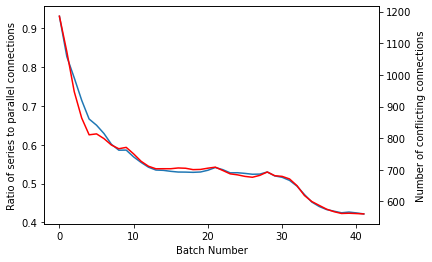

In [216]:
fig, ax1 = plt.subplots()
ax1.plot(ratio_list)
ax1.set_xlabel('Batch Number')
ax1.set_ylabel('Ratio of series to parallel connections')
#ax1.plot(self_connections)
ax2 = ax1.twinx()
ax2.plot(conflicting_connections, 'r')
ax2.set_ylabel('Number of conflicting connections')
#ax2.plot(loss_list, 'r')
plt.savefig('training_graph.png',dpi=300,bbox_inches="tight")

In [ ]:
""" Model evaluation creation - DO NOT RUN"""
evaluation_shading_maps = pd.Series([generate_gaussian(10, 10, 6) for x in range(0, 100)])
print(evaluation_shading_maps)
filename = 'evaluation_series.csv'
with open(filename, 'w', newline='') as f:
    evaluation_shading_maps.to_csv(f, header=["Shading Maps"])

In [73]:
""" Load in evaluation series"""
read_in = pd.read_csv("evaluation_series.csv", header=0, names=['Shading Maps'], usecols=[1])
eval_series = [convert_to_array(s) for s in read_in['Shading Maps']]

In [220]:
class EvalDataset(Dataset):
    def __init__(self, series):
        self.series = series
    def __getitem__(self, index):
        shading_map = self.series[index]
        #print(shading_map)
        shading_map = torch.Tensor(shading_map)/10
        shading_map = shading_map.unsqueeze(0)
        return shading_map
    def __len__(self):
        return len(self.series)
evaldataset = EvalDataset(eval_series)
test_loader = torch.utils.data.DataLoader(evaldataset, batch_size=1)

In [219]:
embedding_list = []
terminal_list = []
power_list = []
tct_list = []
sp_list = []
s_list = []
p_list = []

In [221]:
''' evaluate model & visualise outputs'''
model.eval()
with torch.no_grad():
    # get single random image batch from test dataset
    for s in random.sample(list(test_loader), 100):
        
        # push images to gpu
        shading_map = s.to(device)
        # plot input image
        #plt.imshow(np.squeeze(shading_map))
        #plt.figure()
        # compute output image
        result = model(shading_map)
        #print(result)
        # get output image from gpu, reshape
        
        result = np.squeeze(result).cpu().numpy()
        embedding, terminal_array = result[:10800], result[10800:]        
        #print(embedding.shape)
        #print(terminal_array.shape)
        embedding = embedding.reshape(10, 6, 10, 6, 3)
        embedding = np.array(embedding, dtype=bool)
        
        embedding_list.append(np.copy(embedding)) # copy is required as filter_embedding() modifies both the embedding
                                                  # and the terminal array
        
        terminal_array = terminal_array.reshape(10, 6, 2)
        terminal_array = np.array(terminal_array, dtype=bool)
        
        terminal_list.append(np.copy(terminal_array))
        
        moduleobj = SolarModule(10,6)
        moduleobj.embedding = embedding
        moduleobj.terminal_array = terminal_array
        moduleobj.shading_map = np.squeeze(shading_map).cpu().numpy()*10
        denominator = sum(moduleobj.shading_map.flatten())
        
        #tct = TCT_interconnection(6, 10, moduleobj.shading_map)
        #sp = SP_interconnection(6, 10, moduleobj.shading_map)
        series = all_series_bypass(6, 10, moduleobj.shading_map)
        #tct.V('input', 6, series.gnd, 0)
        #sp.V('input', 1, series.gnd, 0)
        series.V('input', 1, series.gnd, 0)
        simulator = series.simulator(temperature=25, nominal_temperature=25)
        analysis = simulator.dc(Vinput=slice(0,50,0.01))
        #plt.plot(np.array(analysis.sweep), np.array(analysis.Vinput))
        bypassI = np.array(analysis.Vinput)
        bypassV = np.array(analysis.sweep)
        bypassP = bypassI * bypassV
        s_list.append(max(bypassP)/denominator)
        
        try:
            moduleobj.make_netlist()
        except ValueError:
            print(moduleobj.filter_embedding())
            moduleobj.make_netlist()
        try:
            moduleobj.simulate()
            normal_power = moduleobj.MPP/denominator
            power_list.append(round(normal_power, 2))
            p_list.append(round
                          (moduleobj.MPP, 2))
            print("{}, {} W, {} V, {} A".format(round(normal_power, 2), round(moduleobj.MPP, 2), \
                                            round(moduleobj.VMP, 2), round(moduleobj.IMP, 2)))
        #moduleobj.plot_netlist(ymax=300)
        #moduleobj.imshow(3, 3)
        except:
            power_list.append(0)
            p_list.append(0)
            print("Simulation failed")       
        

Invalid embedding: Connection between twocells cannot be both series and parallel.Error occurred at 0001
(0, 561, 2277, 31, 1, 0, 1.0)
0.64, 243.28 W, 0.67 V, 363.1 A
Invalid embedding: Connection between twocells cannot be both series and parallel.Error occurred at 0001
(0, 559, 2275, 31, 1, 0, 1.0)
0.64, 181.61 W, 0.66 V, 275.16 A
Invalid embedding: Connection between twocells cannot be both series and parallel.Error occurred at 0001
(0, 558, 2280, 31, 1, 0, 1.0)
0.64, 208.27 W, 0.66 V, 315.57 A
Invalid embedding: Connection between twocells cannot be both series and parallel.Error occurred at 0001
(0, 551, 2274, 31, 1, 0, 1.0)
0.64, 231.37 W, 0.67 V, 345.32 A
Invalid embedding: Connection between twocells cannot be both series and parallel.Error occurred at 0001
(0, 562, 2278, 31, 1, 0, 1.0)
0.63, 164.95 W, 0.66 V, 249.92 A
Invalid embedding: Connection between twocells cannot be both series and parallel.Error occurred at 0001
(0, 565, 2278, 31, 1, 0, 1.0)
0.64, 190.78 W, 0.66 V, 28

Invalid embedding: Connection between twocells cannot be both series and parallel.Error occurred at 0001
(0, 563, 2278, 31, 1, 0, 1.0)
0.63, 171.04 W, 0.66 V, 259.15 A
Invalid embedding: Connection between twocells cannot be both series and parallel.Error occurred at 0001
(1, 558, 2284, 31, 1, 0, 1.0)
0.64, 224.13 W, 0.66 V, 339.59 A
Invalid embedding: Connection between twocells cannot be both series and parallel.Error occurred at 0001
(0, 557, 2274, 31, 1, 0, 1.0)
0.63, 175.16 W, 0.66 V, 265.39 A
Invalid embedding: Connection between twocells cannot be both series and parallel.Error occurred at 0001
(0, 559, 2276, 31, 1, 0, 1.0)
0.64, 215.37 W, 0.66 V, 326.32 A
Invalid embedding: Connection between twocells cannot be both series and parallel.Error occurred at 0001
(0, 564, 2278, 31, 1, 0, 1.0)
0.64, 264.51 W, 0.67 V, 394.78 A
Invalid embedding: Connection between twocells cannot be both series and parallel.Error occurred at 0001
(0, 561, 2277, 31, 1, 0, 1.0)
0.63, 166.64 W, 0.66 V, 2

Invalid embedding: Connection between twocells cannot be both series and parallel.Error occurred at 0001
(0, 553, 2272, 31, 1, 0, 1.0)
0.64, 208.4 W, 0.66 V, 315.76 A
Invalid embedding: Connection between twocells cannot be both series and parallel.Error occurred at 0001
(0, 562, 2278, 31, 1, 0, 1.0)
0.64, 193.37 W, 0.66 V, 292.99 A


In [118]:
moduleobj.check_embedding()


True

In [26]:
# comparing evaluation embeddings predicted by model to 1000 embeddings in dataset.
thousand_modules = [super_to_embedding(10, 6, x) for x in configurations]
benchmark = [np.append(x.embedding.flatten(), x.terminal_array.flatten()) for x in thousand_modules]
print(benchmark[0].shape)    
comparison = [np.append(embedding_list[x].flatten(), terminal_list[x].flatten()) for x in range(0, len(embedding_list))]
print(len(comparison))
print(len(comparison[0]))

difference_list = []
for model_output in comparison:
    difference = []
    for array in benchmark:
        value = sum(model_output ^ array)
        print(value)
        difference.append(value)
    difference_list.append(difference)

KeyboardInterrupt: 

In [26]:
for x in difference_list:
    print(x.index(min(x)), end=' ')

In [27]:
print(min(x))

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

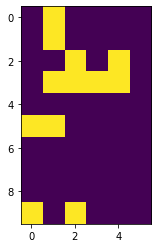

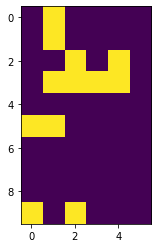

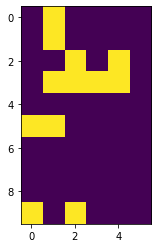

In [50]:
r, c = 2,0
plt.imshow(embedding_list[0][r,c,...,2])
plt.figure()
plt.imshow(embedding_list[34][r,c,...,2])
plt.figure()
plt.imshow(embedding_list[72][r,c,...,2])

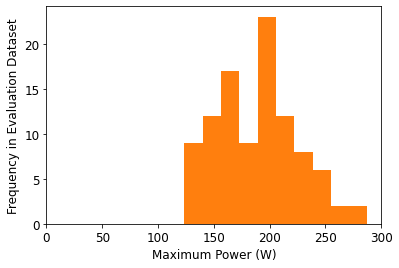

In [51]:
fig, ax = plt.subplots()
ax.hist(p_list, color='C1')
ax.set_xlabel('Maximum Power (W)',fontsize='large')
ax.set_ylabel('Frequency in Evaluation Dataset',fontsize='large')
ax.tick_params(axis='both', labelsize='large')
ax.set_xlim(0,300)
fig.savefig('histogram.png',dpi=300,bbox_inches="tight")

In [218]:
''' save model checkpoint '''

# set model checkpoint path inc. hyperparams
_path = 'Checkpoints/Batch42FromInit.pth'
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
}, _path)


In [199]:
""" load model checkpoint """
''' load model checkpoint from file '''

# init model and optimiser
#model = TheModelClass(*args, **kwargs)
#optimizer = TheOptimizerClass(*args, **kwargs)

#_path = '../data/model/cnn-vae-f16-k5-z128-i121-v01.pth'
#_path = '../data/model/cnn-vae-f16-k3-z128-i115-v01.pth'
_path = 'supervised-f8-k3-z256-conflict4-no351.pth'

# load checkpoint
checkpoint = torch.load(_path)

# update model
#model.load_state_dict(checkpoint['model_state_dict'])
model.load_state_dict(checkpoint['model_state_dict'])

# update optimiser
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# set epoch and loss
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# set model train/eval state
#model.eval()
#model.train()

In [27]:
new_eval_shading_maps = pd.Series([generate_gaussian(10, 10, 6) for x in range(0, 100)])
#print(new_eval_shading_maps)
filename = 'new_eval_shading_maps.csv'
with open(filename, 'w', newline='') as f:
    new_eval_shading_maps.to_csv(f, header=["Shading Maps"])
read_in = pd.read_csv("new_eval_shading_maps.csv", header=0, names=['Shading Maps'], usecols=[1])
new_eval_series = [convert_to_array(s) for s in read_in['Shading Maps']]

In [90]:
filename = 'conflict4-no351_embedding_simulations.csv'
with open(filename, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Embedding No.', 'Map No.', 'Normalised Power', 'MPP', 'VMP', 'IMP', 'Filtered Embedding?'])
    for embedding_no, embedding in enumerate(embedding_list):
        
        terminal_array = terminal_list[embedding_no] # get corresponding terminal array for embedding
        
        moduleobj = SolarModule(10,6)
        moduleobj.embedding = np.copy(embedding)
        moduleobj.terminal_array = np.copy(terminal_array)
        
        try:
            moduleobj.make_netlist()
            modified = False
        except ValueError:
            moduleobj.filter_embedding()
            moduleobj.make_netlist()
            modified = True
        
        for map_no, shading_map in enumerate(new_eval_series):
            moduleobj.shading_map = shading_map
            denominator = sum(moduleobj.shading_map.flatten())
            moduleobj.make_netlist()
            moduleobj.simulate()
            normal_power = moduleobj.MPP/denominator
            print("embedding {}, shading map {}, {} %, {} W, {} V, {} A, modified {}".format(embedding_no, map_no, \
                                            round(normal_power, 2), round(moduleobj.MPP, 2), \
                                            round(moduleobj.VMP, 2), round(moduleobj.IMP, 2), modified))
            writer.writerow([embedding_no, map_no, round(normal_power, 2), round(moduleobj.MPP, 2), \
                            round(moduleobj.VMP, 2), round(moduleobj.IMP, 2), modified])

Invalid embedding: Connection between twocells cannot be both series and parallel.Error occurred at 3031
embedding 0, shading map 0, 0.62 %, 177.06 W, 0.66 V, 268.27 A, modified True
embedding 0, shading map 1, 0.62 %, 207.72 W, 0.66 V, 314.73 A, modified True
embedding 0, shading map 2, 0.61 %, 154.28 W, 0.66 V, 233.76 A, modified True
embedding 0, shading map 3, 0.62 %, 224.0 W, 0.67 V, 334.32 A, modified True
embedding 0, shading map 4, 0.61 %, 235.89 W, 0.67 V, 352.08 A, modified True
embedding 0, shading map 5, 0.63 %, 248.97 W, 0.67 V, 371.59 A, modified True
embedding 0, shading map 6, 0.62 %, 161.61 W, 0.66 V, 244.86 A, modified True
embedding 0, shading map 7, 0.61 %, 176.99 W, 0.66 V, 268.16 A, modified True
embedding 0, shading map 8, 0.63 %, 238.03 W, 0.67 V, 355.27 A, modified True
embedding 0, shading map 9, 0.6 %, 160.37 W, 0.66 V, 242.98 A, modified True
embedding 0, shading map 10, 0.63 %, 236.25 W, 0.67 V, 352.61 A, modified True
embedding 0, shading map 11, 0.62 %, 2

Exception ignored from cffi callback <function NgSpiceShared._send_stat at 0x15662fd30>:
Traceback (most recent call last):
  File "/Users/mlima/opt/anaconda3/lib/python3.9/site-packages/PySpice/Spice/NgSpice/Shared.py", line 644, in _send_stat
    @staticmethod
KeyboardInterrupt: 


embedding 0, shading map 53, 0.63 %, 173.73 W, 0.66 V, 263.22 A, modified True
embedding 0, shading map 54, 0.63 %, 206.58 W, 0.66 V, 313.0 A, modified True
embedding 0, shading map 55, 0.61 %, 225.24 W, 0.67 V, 336.18 A, modified True
embedding 0, shading map 56, 0.6 %, 209.82 W, 0.66 V, 317.91 A, modified True
embedding 0, shading map 57, 0.63 %, 242.4 W, 0.67 V, 361.79 A, modified True
embedding 0, shading map 58, 0.61 %, 232.14 W, 0.67 V, 346.47 A, modified True
embedding 0, shading map 59, 0.61 %, 219.98 W, 0.66 V, 333.3 A, modified True
embedding 0, shading map 60, 0.62 %, 293.19 W, 0.67 V, 437.6 A, modified True
embedding 0, shading map 61, 0.62 %, 214.14 W, 0.66 V, 324.45 A, modified True
embedding 0, shading map 62, 0.62 %, 200.27 W, 0.66 V, 303.44 A, modified True
embedding 0, shading map 63, 0.6 %, 167.87 W, 0.66 V, 254.35 A, modified True
embedding 0, shading map 64, 0.62 %, 193.11 W, 0.66 V, 292.59 A, modified True
embedding 0, shading map 65, 0.6 %, 130.85 W, 0.65 V, 201.

embedding 1, shading map 58, 0.61 %, 232.14 W, 0.67 V, 346.47 A, modified True
embedding 1, shading map 59, 0.61 %, 219.98 W, 0.66 V, 333.3 A, modified True
embedding 1, shading map 60, 0.62 %, 293.19 W, 0.67 V, 437.6 A, modified True
embedding 1, shading map 61, 0.62 %, 214.14 W, 0.66 V, 324.45 A, modified True
embedding 1, shading map 62, 0.62 %, 200.27 W, 0.66 V, 303.44 A, modified True
embedding 1, shading map 63, 0.6 %, 167.87 W, 0.66 V, 254.35 A, modified True
embedding 1, shading map 64, 0.62 %, 193.11 W, 0.66 V, 292.59 A, modified True
embedding 1, shading map 65, 0.6 %, 130.85 W, 0.65 V, 201.31 A, modified True
embedding 1, shading map 66, 0.63 %, 208.74 W, 0.66 V, 316.27 A, modified True
embedding 1, shading map 67, 0.62 %, 200.53 W, 0.66 V, 303.83 A, modified True
embedding 1, shading map 68, 0.63 %, 181.35 W, 0.66 V, 274.77 A, modified True
embedding 1, shading map 69, 0.63 %, 201.17 W, 0.66 V, 304.8 A, modified True
embedding 1, shading map 70, 0.62 %, 229.4 W, 0.67 V, 342

embedding 2, shading map 63, 0.59 %, 166.21 W, 0.66 V, 251.83 A, modified True
embedding 2, shading map 64, 0.6 %, 186.65 W, 0.66 V, 282.8 A, modified True
embedding 2, shading map 65, 0.58 %, 127.88 W, 0.65 V, 196.74 A, modified True
embedding 2, shading map 66, 0.61 %, 202.28 W, 0.66 V, 306.48 A, modified True
embedding 2, shading map 67, 0.62 %, 199.35 W, 0.66 V, 302.05 A, modified True
embedding 2, shading map 68, 0.63 %, 181.44 W, 0.66 V, 274.91 A, modified True
embedding 2, shading map 69, 0.61 %, 194.71 W, 0.66 V, 295.02 A, modified True
embedding 2, shading map 70, 0.61 %, 226.69 W, 0.67 V, 338.34 A, modified True
embedding 2, shading map 71, 0.64 %, 253.03 W, 0.67 V, 377.65 A, modified True
embedding 2, shading map 72, 0.59 %, 145.53 W, 0.66 V, 220.5 A, modified True
embedding 2, shading map 73, 0.56 %, 130.21 W, 0.65 V, 200.32 A, modified True
embedding 2, shading map 74, 0.6 %, 207.23 W, 0.66 V, 313.99 A, modified True
embedding 2, shading map 75, 0.61 %, 154.7 W, 0.66 V, 23

embedding 3, shading map 68, 0.63 %, 181.35 W, 0.66 V, 274.77 A, modified True
embedding 3, shading map 69, 0.63 %, 201.17 W, 0.66 V, 304.8 A, modified True
embedding 3, shading map 70, 0.62 %, 229.4 W, 0.67 V, 342.38 A, modified True
embedding 3, shading map 71, 0.64 %, 252.88 W, 0.67 V, 377.44 A, modified True
embedding 3, shading map 72, 0.6 %, 149.82 W, 0.66 V, 227.0 A, modified True
embedding 3, shading map 73, 0.58 %, 133.23 W, 0.65 V, 204.98 A, modified True
embedding 3, shading map 74, 0.61 %, 212.33 W, 0.66 V, 321.72 A, modified True
embedding 3, shading map 75, 0.61 %, 154.72 W, 0.66 V, 234.42 A, modified True
embedding 3, shading map 76, 0.61 %, 177.06 W, 0.66 V, 268.27 A, modified True
embedding 3, shading map 77, 0.62 %, 234.16 W, 0.67 V, 349.49 A, modified True
embedding 3, shading map 78, 0.61 %, 194.57 W, 0.66 V, 294.8 A, modified True
embedding 3, shading map 79, 0.61 %, 229.66 W, 0.67 V, 342.77 A, modified True
embedding 3, shading map 80, 0.61 %, 194.66 W, 0.66 V, 29

embedding 4, shading map 73, 0.58 %, 133.23 W, 0.65 V, 204.98 A, modified True
embedding 4, shading map 74, 0.61 %, 212.33 W, 0.66 V, 321.72 A, modified True
embedding 4, shading map 75, 0.61 %, 154.72 W, 0.66 V, 234.42 A, modified True
embedding 4, shading map 76, 0.61 %, 177.06 W, 0.66 V, 268.27 A, modified True
embedding 4, shading map 77, 0.62 %, 234.16 W, 0.67 V, 349.49 A, modified True
embedding 4, shading map 78, 0.61 %, 194.57 W, 0.66 V, 294.8 A, modified True
embedding 4, shading map 79, 0.61 %, 229.66 W, 0.67 V, 342.77 A, modified True
embedding 4, shading map 80, 0.61 %, 194.66 W, 0.66 V, 294.94 A, modified True
embedding 4, shading map 81, 0.6 %, 196.03 W, 0.66 V, 297.01 A, modified True
embedding 4, shading map 82, 0.62 %, 193.67 W, 0.66 V, 293.45 A, modified True
embedding 4, shading map 83, 0.62 %, 256.53 W, 0.67 V, 382.88 A, modified True
embedding 4, shading map 84, 0.62 %, 122.73 W, 0.65 V, 188.82 A, modified True
embedding 4, shading map 85, 0.6 %, 201.25 W, 0.66 V, 

embedding 5, shading map 76, 0.61 %, 177.06 W, 0.66 V, 268.27 A, modified True
embedding 5, shading map 77, 0.62 %, 234.16 W, 0.67 V, 349.49 A, modified True
embedding 5, shading map 78, 0.61 %, 194.57 W, 0.66 V, 294.8 A, modified True
embedding 5, shading map 79, 0.61 %, 229.66 W, 0.67 V, 342.77 A, modified True
embedding 5, shading map 80, 0.61 %, 194.66 W, 0.66 V, 294.94 A, modified True
embedding 5, shading map 81, 0.6 %, 196.03 W, 0.66 V, 297.01 A, modified True
embedding 5, shading map 82, 0.62 %, 193.67 W, 0.66 V, 293.45 A, modified True
embedding 5, shading map 83, 0.62 %, 256.53 W, 0.67 V, 382.88 A, modified True
embedding 5, shading map 84, 0.62 %, 122.73 W, 0.65 V, 188.82 A, modified True
embedding 5, shading map 85, 0.6 %, 201.25 W, 0.66 V, 304.92 A, modified True
embedding 5, shading map 86, 0.61 %, 248.07 W, 0.67 V, 370.25 A, modified True
embedding 5, shading map 87, 0.64 %, 180.98 W, 0.66 V, 274.21 A, modified True
embedding 5, shading map 88, 0.62 %, 189.35 W, 0.66 V, 

embedding 6, shading map 81, 0.6 %, 196.03 W, 0.66 V, 297.01 A, modified True
embedding 6, shading map 82, 0.62 %, 193.67 W, 0.66 V, 293.45 A, modified True
embedding 6, shading map 83, 0.62 %, 256.53 W, 0.67 V, 382.88 A, modified True
embedding 6, shading map 84, 0.62 %, 122.73 W, 0.65 V, 188.82 A, modified True
embedding 6, shading map 85, 0.6 %, 201.25 W, 0.66 V, 304.92 A, modified True
embedding 6, shading map 86, 0.61 %, 248.07 W, 0.67 V, 370.25 A, modified True
embedding 6, shading map 87, 0.64 %, 180.98 W, 0.66 V, 274.21 A, modified True
embedding 6, shading map 88, 0.62 %, 189.35 W, 0.66 V, 286.9 A, modified True
embedding 6, shading map 89, 0.62 %, 225.65 W, 0.67 V, 336.79 A, modified True
embedding 6, shading map 90, 0.61 %, 148.54 W, 0.66 V, 225.06 A, modified True
embedding 6, shading map 91, 0.62 %, 222.77 W, 0.67 V, 332.49 A, modified True
embedding 6, shading map 92, 0.63 %, 213.33 W, 0.66 V, 323.23 A, modified True
embedding 6, shading map 93, 0.62 %, 145.18 W, 0.66 V, 

embedding 7, shading map 86, 0.6 %, 241.58 W, 0.67 V, 360.56 A, modified True
embedding 7, shading map 87, 0.63 %, 179.75 W, 0.66 V, 272.35 A, modified True
embedding 7, shading map 88, 0.6 %, 182.89 W, 0.66 V, 277.11 A, modified True
embedding 7, shading map 89, 0.62 %, 224.91 W, 0.67 V, 335.69 A, modified True
embedding 7, shading map 90, 0.61 %, 148.14 W, 0.66 V, 224.45 A, modified True
embedding 7, shading map 91, 0.6 %, 217.16 W, 0.66 V, 329.03 A, modified True
embedding 7, shading map 92, 0.61 %, 206.87 W, 0.66 V, 313.44 A, modified True
embedding 7, shading map 93, 0.62 %, 144.95 W, 0.66 V, 219.63 A, modified True
embedding 7, shading map 94, 0.59 %, 162.23 W, 0.66 V, 245.81 A, modified True
embedding 7, shading map 95, 0.6 %, 186.65 W, 0.66 V, 282.8 A, modified True
embedding 7, shading map 96, 0.62 %, 178.26 W, 0.66 V, 270.09 A, modified True
embedding 7, shading map 97, 0.59 %, 214.14 W, 0.66 V, 324.45 A, modified True
embedding 7, shading map 98, 0.59 %, 202.07 W, 0.66 V, 30

embedding 8, shading map 89, 0.62 %, 225.65 W, 0.67 V, 336.79 A, modified True
embedding 8, shading map 90, 0.61 %, 148.54 W, 0.66 V, 225.06 A, modified True
embedding 8, shading map 91, 0.62 %, 222.77 W, 0.67 V, 332.49 A, modified True
embedding 8, shading map 92, 0.63 %, 213.33 W, 0.66 V, 323.23 A, modified True
embedding 8, shading map 93, 0.62 %, 145.18 W, 0.66 V, 219.97 A, modified True
embedding 8, shading map 94, 0.61 %, 168.69 W, 0.66 V, 255.59 A, modified True
embedding 8, shading map 95, 0.6 %, 187.15 W, 0.66 V, 283.55 A, modified True
embedding 8, shading map 96, 0.64 %, 183.24 W, 0.66 V, 277.63 A, modified True
embedding 8, shading map 97, 0.6 %, 220.6 W, 0.66 V, 334.24 A, modified True
embedding 8, shading map 98, 0.6 %, 206.7 W, 0.66 V, 313.18 A, modified True
embedding 8, shading map 99, 0.61 %, 203.03 W, 0.66 V, 307.63 A, modified True
Invalid embedding: Connection between twocells cannot be both series and parallel.Error occurred at 3031
embedding 9, shading map 0, 0.6

embedding 9, shading map 94, 0.59 %, 162.23 W, 0.66 V, 245.81 A, modified True
embedding 9, shading map 95, 0.6 %, 186.65 W, 0.66 V, 282.8 A, modified True
embedding 9, shading map 96, 0.62 %, 178.26 W, 0.66 V, 270.09 A, modified True
embedding 9, shading map 97, 0.59 %, 214.14 W, 0.66 V, 324.45 A, modified True
embedding 9, shading map 98, 0.59 %, 202.07 W, 0.66 V, 306.17 A, modified True
embedding 9, shading map 99, 0.59 %, 196.93 W, 0.66 V, 298.39 A, modified True
Invalid embedding: Connection between twocells cannot be both series and parallel.Error occurred at 3031
embedding 10, shading map 0, 0.62 %, 177.06 W, 0.66 V, 268.27 A, modified True
embedding 10, shading map 1, 0.62 %, 207.72 W, 0.66 V, 314.73 A, modified True
embedding 10, shading map 2, 0.61 %, 154.28 W, 0.66 V, 233.76 A, modified True
embedding 10, shading map 3, 0.62 %, 224.0 W, 0.67 V, 334.32 A, modified True
embedding 10, shading map 4, 0.61 %, 235.89 W, 0.67 V, 352.08 A, modified True
embedding 10, shading map 5, 

embedding 10, shading map 96, 0.64 %, 183.24 W, 0.66 V, 277.63 A, modified True
embedding 10, shading map 97, 0.6 %, 220.6 W, 0.66 V, 334.24 A, modified True
embedding 10, shading map 98, 0.6 %, 206.7 W, 0.66 V, 313.18 A, modified True
embedding 10, shading map 99, 0.61 %, 203.03 W, 0.66 V, 307.63 A, modified True
Invalid embedding: Connection between twocells cannot be both series and parallel.Error occurred at 3031
embedding 11, shading map 0, 0.62 %, 177.06 W, 0.66 V, 268.27 A, modified True
embedding 11, shading map 1, 0.62 %, 207.72 W, 0.66 V, 314.73 A, modified True
embedding 11, shading map 2, 0.61 %, 154.28 W, 0.66 V, 233.76 A, modified True
embedding 11, shading map 3, 0.62 %, 224.0 W, 0.67 V, 334.32 A, modified True
embedding 11, shading map 4, 0.61 %, 235.89 W, 0.67 V, 352.08 A, modified True
embedding 11, shading map 5, 0.63 %, 248.97 W, 0.67 V, 371.59 A, modified True
embedding 11, shading map 6, 0.62 %, 161.61 W, 0.66 V, 244.86 A, modified True
embedding 11, shading map 7

embedding 11, shading map 99, 0.61 %, 203.03 W, 0.66 V, 307.63 A, modified True
Invalid embedding: Connection between twocells cannot be both series and parallel.Error occurred at 3031
embedding 12, shading map 0, 0.62 %, 177.06 W, 0.66 V, 268.27 A, modified True
embedding 12, shading map 1, 0.62 %, 207.72 W, 0.66 V, 314.73 A, modified True
embedding 12, shading map 2, 0.61 %, 154.28 W, 0.66 V, 233.76 A, modified True
embedding 12, shading map 3, 0.62 %, 224.0 W, 0.67 V, 334.32 A, modified True
embedding 12, shading map 4, 0.61 %, 235.89 W, 0.67 V, 352.08 A, modified True
embedding 12, shading map 5, 0.63 %, 248.97 W, 0.67 V, 371.59 A, modified True
embedding 12, shading map 6, 0.62 %, 161.61 W, 0.66 V, 244.86 A, modified True
embedding 12, shading map 7, 0.61 %, 176.99 W, 0.66 V, 268.16 A, modified True
embedding 12, shading map 8, 0.63 %, 238.03 W, 0.67 V, 355.27 A, modified True
embedding 12, shading map 9, 0.6 %, 160.37 W, 0.66 V, 242.98 A, modified True
embedding 12, shading map 1

embedding 13, shading map 0, 0.62 %, 177.06 W, 0.66 V, 268.27 A, modified True
embedding 13, shading map 1, 0.62 %, 207.72 W, 0.66 V, 314.73 A, modified True
embedding 13, shading map 2, 0.61 %, 154.28 W, 0.66 V, 233.76 A, modified True
embedding 13, shading map 3, 0.62 %, 224.0 W, 0.67 V, 334.32 A, modified True
embedding 13, shading map 4, 0.61 %, 235.89 W, 0.67 V, 352.08 A, modified True
embedding 13, shading map 5, 0.63 %, 248.97 W, 0.67 V, 371.59 A, modified True
embedding 13, shading map 6, 0.62 %, 161.61 W, 0.66 V, 244.86 A, modified True
embedding 13, shading map 7, 0.61 %, 176.99 W, 0.66 V, 268.16 A, modified True
embedding 13, shading map 8, 0.63 %, 238.03 W, 0.67 V, 355.27 A, modified True
embedding 13, shading map 9, 0.6 %, 160.37 W, 0.66 V, 242.98 A, modified True
embedding 13, shading map 10, 0.63 %, 236.25 W, 0.67 V, 352.61 A, modified True
embedding 13, shading map 11, 0.62 %, 217.87 W, 0.66 V, 330.1 A, modified True
embedding 13, shading map 12, 0.61 %, 218.35 W, 0.66 

embedding 14, shading map 2, 0.61 %, 154.1 W, 0.66 V, 233.49 A, modified True
embedding 14, shading map 3, 0.61 %, 218.21 W, 0.67 V, 325.68 A, modified True
embedding 14, shading map 4, 0.6 %, 229.4 W, 0.67 V, 342.39 A, modified True
embedding 14, shading map 5, 0.62 %, 242.48 W, 0.67 V, 361.9 A, modified True
embedding 14, shading map 6, 0.59 %, 155.15 W, 0.66 V, 235.07 A, modified True
embedding 14, shading map 7, 0.6 %, 174.61 W, 0.66 V, 264.56 A, modified True
embedding 14, shading map 8, 0.62 %, 235.65 W, 0.67 V, 351.72 A, modified True
embedding 14, shading map 9, 0.58 %, 153.91 W, 0.66 V, 233.19 A, modified True
embedding 14, shading map 10, 0.61 %, 230.0 W, 0.67 V, 343.28 A, modified True
embedding 14, shading map 11, 0.62 %, 217.45 W, 0.67 V, 324.55 A, modified True
embedding 14, shading map 12, 0.6 %, 212.22 W, 0.66 V, 321.54 A, modified True
embedding 14, shading map 13, 0.6 %, 148.37 W, 0.66 V, 224.8 A, modified True
embedding 14, shading map 14, 0.63 %, 195.01 W, 0.66 V, 2

embedding 15, shading map 4, 0.61 %, 235.89 W, 0.67 V, 352.08 A, modified True
embedding 15, shading map 5, 0.63 %, 248.97 W, 0.67 V, 371.59 A, modified True
embedding 15, shading map 6, 0.62 %, 161.61 W, 0.66 V, 244.86 A, modified True
embedding 15, shading map 7, 0.61 %, 176.99 W, 0.66 V, 268.16 A, modified True
embedding 15, shading map 8, 0.63 %, 238.03 W, 0.67 V, 355.27 A, modified True
embedding 15, shading map 9, 0.6 %, 160.37 W, 0.66 V, 242.98 A, modified True
embedding 15, shading map 10, 0.63 %, 236.25 W, 0.67 V, 352.61 A, modified True
embedding 15, shading map 11, 0.62 %, 217.87 W, 0.66 V, 330.1 A, modified True
embedding 15, shading map 12, 0.61 %, 218.35 W, 0.66 V, 330.83 A, modified True
embedding 15, shading map 13, 0.6 %, 149.9 W, 0.66 V, 227.12 A, modified True
embedding 15, shading map 14, 0.63 %, 196.12 W, 0.66 V, 297.16 A, modified True
embedding 15, shading map 15, 0.59 %, 166.91 W, 0.66 V, 252.89 A, modified True
embedding 15, shading map 16, 0.62 %, 183.57 W, 0.

embedding 16, shading map 7, 0.61 %, 176.99 W, 0.66 V, 268.16 A, modified True
embedding 16, shading map 8, 0.63 %, 238.03 W, 0.67 V, 355.27 A, modified True
embedding 16, shading map 9, 0.6 %, 160.37 W, 0.66 V, 242.98 A, modified True
embedding 16, shading map 10, 0.63 %, 236.25 W, 0.67 V, 352.61 A, modified True
embedding 16, shading map 11, 0.62 %, 217.87 W, 0.66 V, 330.1 A, modified True
embedding 16, shading map 12, 0.61 %, 218.35 W, 0.66 V, 330.83 A, modified True
embedding 16, shading map 13, 0.6 %, 149.9 W, 0.66 V, 227.12 A, modified True
embedding 16, shading map 14, 0.63 %, 196.12 W, 0.66 V, 297.16 A, modified True
embedding 16, shading map 15, 0.59 %, 166.91 W, 0.66 V, 252.89 A, modified True
embedding 16, shading map 16, 0.62 %, 183.57 W, 0.66 V, 278.13 A, modified True
embedding 16, shading map 17, 0.62 %, 234.94 W, 0.67 V, 350.66 A, modified True
embedding 16, shading map 18, 0.59 %, 161.32 W, 0.66 V, 244.43 A, modified True
embedding 16, shading map 19, 0.58 %, 152.56 W,

embedding 17, shading map 10, 0.61 %, 230.0 W, 0.67 V, 343.28 A, modified True
embedding 17, shading map 11, 0.62 %, 217.45 W, 0.67 V, 324.55 A, modified True
embedding 17, shading map 12, 0.6 %, 212.22 W, 0.66 V, 321.54 A, modified True
embedding 17, shading map 13, 0.6 %, 148.37 W, 0.66 V, 224.8 A, modified True
embedding 17, shading map 14, 0.63 %, 195.01 W, 0.66 V, 295.48 A, modified True
embedding 17, shading map 15, 0.58 %, 163.3 W, 0.66 V, 247.43 A, modified True
embedding 17, shading map 16, 0.62 %, 183.16 W, 0.66 V, 277.51 A, modified True
embedding 17, shading map 17, 0.6 %, 228.45 W, 0.67 V, 340.97 A, modified True
embedding 17, shading map 18, 0.57 %, 154.86 W, 0.66 V, 234.64 A, modified True
embedding 17, shading map 19, 0.58 %, 152.42 W, 0.66 V, 230.94 A, modified True
embedding 17, shading map 20, 0.64 %, 213.48 W, 0.66 V, 323.45 A, modified True
embedding 17, shading map 21, 0.62 %, 153.35 W, 0.66 V, 232.34 A, modified True
embedding 17, shading map 22, 0.6 %, 224.18 W,

embedding 18, shading map 12, 0.61 %, 218.35 W, 0.66 V, 330.83 A, modified True
embedding 18, shading map 13, 0.6 %, 149.9 W, 0.66 V, 227.12 A, modified True
embedding 18, shading map 14, 0.63 %, 196.12 W, 0.66 V, 297.16 A, modified True
embedding 18, shading map 15, 0.59 %, 166.91 W, 0.66 V, 252.89 A, modified True
embedding 18, shading map 16, 0.62 %, 183.57 W, 0.66 V, 278.13 A, modified True
embedding 18, shading map 17, 0.62 %, 234.94 W, 0.67 V, 350.66 A, modified True
embedding 18, shading map 18, 0.59 %, 161.32 W, 0.66 V, 244.43 A, modified True
embedding 18, shading map 19, 0.58 %, 152.56 W, 0.66 V, 231.15 A, modified True
embedding 18, shading map 20, 0.64 %, 214.05 W, 0.66 V, 324.32 A, modified True
embedding 18, shading map 21, 0.62 %, 153.45 W, 0.66 V, 232.5 A, modified True
embedding 18, shading map 22, 0.62 %, 230.67 W, 0.67 V, 344.29 A, modified True
embedding 18, shading map 23, 0.61 %, 161.53 W, 0.66 V, 244.75 A, modified True
embedding 18, shading map 24, 0.6 %, 219.78

embedding 19, shading map 14, 0.63 %, 195.01 W, 0.66 V, 295.48 A, modified True
embedding 19, shading map 15, 0.58 %, 163.3 W, 0.66 V, 247.43 A, modified True
embedding 19, shading map 16, 0.62 %, 183.16 W, 0.66 V, 277.51 A, modified True
embedding 19, shading map 17, 0.6 %, 228.45 W, 0.67 V, 340.97 A, modified True
embedding 19, shading map 18, 0.57 %, 154.86 W, 0.66 V, 234.64 A, modified True
embedding 19, shading map 19, 0.58 %, 152.42 W, 0.66 V, 230.94 A, modified True
embedding 19, shading map 20, 0.64 %, 213.48 W, 0.66 V, 323.45 A, modified True
embedding 19, shading map 21, 0.62 %, 153.35 W, 0.66 V, 232.34 A, modified True
embedding 19, shading map 22, 0.6 %, 224.18 W, 0.67 V, 334.6 A, modified True
embedding 19, shading map 23, 0.6 %, 159.16 W, 0.66 V, 241.15 A, modified True
embedding 19, shading map 24, 0.6 %, 219.39 W, 0.67 V, 327.45 A, modified True
embedding 19, shading map 25, 0.59 %, 184.89 W, 0.66 V, 280.14 A, modified True
embedding 19, shading map 26, 0.6 %, 162.68 W,

embedding 20, shading map 16, 0.62 %, 183.16 W, 0.66 V, 277.51 A, modified True
embedding 20, shading map 17, 0.6 %, 228.45 W, 0.67 V, 340.97 A, modified True
embedding 20, shading map 18, 0.57 %, 154.86 W, 0.66 V, 234.64 A, modified True
embedding 20, shading map 19, 0.58 %, 152.42 W, 0.66 V, 230.94 A, modified True
embedding 20, shading map 20, 0.64 %, 213.48 W, 0.66 V, 323.45 A, modified True
embedding 20, shading map 21, 0.62 %, 153.35 W, 0.66 V, 232.34 A, modified True
embedding 20, shading map 22, 0.6 %, 224.18 W, 0.67 V, 334.6 A, modified True
embedding 20, shading map 23, 0.6 %, 159.16 W, 0.66 V, 241.15 A, modified True
embedding 20, shading map 24, 0.6 %, 219.39 W, 0.67 V, 327.45 A, modified True
embedding 20, shading map 25, 0.59 %, 184.89 W, 0.66 V, 280.14 A, modified True
embedding 20, shading map 26, 0.6 %, 162.68 W, 0.66 V, 246.49 A, modified True
embedding 20, shading map 27, 0.6 %, 163.04 W, 0.66 V, 247.03 A, modified True
embedding 20, shading map 28, 0.59 %, 170.21 W,

embedding 21, shading map 19, 0.58 %, 152.56 W, 0.66 V, 231.15 A, modified True
embedding 21, shading map 20, 0.64 %, 214.05 W, 0.66 V, 324.32 A, modified True
embedding 21, shading map 21, 0.62 %, 153.45 W, 0.66 V, 232.5 A, modified True
embedding 21, shading map 22, 0.62 %, 230.67 W, 0.67 V, 344.29 A, modified True
embedding 21, shading map 23, 0.61 %, 161.53 W, 0.66 V, 244.75 A, modified True
embedding 21, shading map 24, 0.6 %, 219.78 W, 0.66 V, 332.99 A, modified True
embedding 21, shading map 25, 0.61 %, 188.25 W, 0.66 V, 285.23 A, modified True
embedding 21, shading map 26, 0.61 %, 165.32 W, 0.66 V, 250.48 A, modified True
embedding 21, shading map 27, 0.6 %, 163.71 W, 0.66 V, 248.04 A, modified True
embedding 21, shading map 28, 0.6 %, 172.08 W, 0.66 V, 260.73 A, modified True
embedding 21, shading map 29, 0.61 %, 212.82 W, 0.66 V, 322.45 A, modified True
embedding 21, shading map 30, 0.63 %, 270.44 W, 0.67 V, 403.64 A, modified True
embedding 21, shading map 31, 0.61 %, 171.67

embedding 22, shading map 22, 0.6 %, 224.18 W, 0.67 V, 334.6 A, modified True
embedding 22, shading map 23, 0.6 %, 159.16 W, 0.66 V, 241.15 A, modified True
embedding 22, shading map 24, 0.6 %, 219.39 W, 0.67 V, 327.45 A, modified True
embedding 22, shading map 25, 0.59 %, 184.89 W, 0.66 V, 280.14 A, modified True
embedding 22, shading map 26, 0.6 %, 162.68 W, 0.66 V, 246.49 A, modified True
embedding 22, shading map 27, 0.6 %, 163.04 W, 0.66 V, 247.03 A, modified True
embedding 22, shading map 28, 0.59 %, 170.21 W, 0.66 V, 257.89 A, modified True
embedding 22, shading map 29, 0.59 %, 206.36 W, 0.66 V, 312.67 A, modified True
embedding 22, shading map 30, 0.61 %, 264.44 W, 0.67 V, 394.69 A, modified True
embedding 22, shading map 31, 0.58 %, 165.21 W, 0.66 V, 250.32 A, modified True
embedding 22, shading map 32, 0.61 %, 156.72 W, 0.66 V, 237.46 A, modified True
embedding 22, shading map 33, 0.62 %, 159.57 W, 0.66 V, 241.77 A, modified True
embedding 22, shading map 34, 0.63 %, 233.14 W

embedding 23, shading map 25, 0.59 %, 184.89 W, 0.66 V, 280.14 A, modified True
embedding 23, shading map 26, 0.6 %, 162.68 W, 0.66 V, 246.49 A, modified True
embedding 23, shading map 27, 0.6 %, 163.04 W, 0.66 V, 247.03 A, modified True
embedding 23, shading map 28, 0.59 %, 170.21 W, 0.66 V, 257.89 A, modified True
embedding 23, shading map 29, 0.59 %, 206.36 W, 0.66 V, 312.67 A, modified True
embedding 23, shading map 30, 0.61 %, 264.44 W, 0.67 V, 394.69 A, modified True
embedding 23, shading map 31, 0.58 %, 165.21 W, 0.66 V, 250.32 A, modified True
embedding 23, shading map 32, 0.61 %, 156.72 W, 0.66 V, 237.46 A, modified True
embedding 23, shading map 33, 0.62 %, 159.57 W, 0.66 V, 241.77 A, modified True
embedding 23, shading map 34, 0.63 %, 233.14 W, 0.67 V, 347.97 A, modified True
embedding 23, shading map 35, 0.59 %, 175.94 W, 0.66 V, 266.58 A, modified True
embedding 23, shading map 36, 0.6 %, 238.55 W, 0.67 V, 356.04 A, modified True
embedding 23, shading map 37, 0.61 %, 274.4

embedding 24, shading map 28, 0.59 %, 170.21 W, 0.66 V, 257.89 A, modified True
embedding 24, shading map 29, 0.59 %, 206.36 W, 0.66 V, 312.67 A, modified True
embedding 24, shading map 30, 0.61 %, 264.44 W, 0.67 V, 394.69 A, modified True
embedding 24, shading map 31, 0.58 %, 165.21 W, 0.66 V, 250.32 A, modified True
embedding 24, shading map 32, 0.61 %, 156.72 W, 0.66 V, 237.46 A, modified True
embedding 24, shading map 33, 0.62 %, 159.57 W, 0.66 V, 241.77 A, modified True
embedding 24, shading map 34, 0.63 %, 233.14 W, 0.67 V, 347.97 A, modified True
embedding 24, shading map 35, 0.59 %, 175.94 W, 0.66 V, 266.58 A, modified True
embedding 24, shading map 36, 0.6 %, 238.55 W, 0.67 V, 356.04 A, modified True
embedding 24, shading map 37, 0.61 %, 274.43 W, 0.67 V, 409.6 A, modified True
embedding 24, shading map 38, 0.58 %, 179.03 W, 0.66 V, 271.26 A, modified True
embedding 24, shading map 39, 0.6 %, 201.11 W, 0.66 V, 304.71 A, modified True
embedding 24, shading map 40, 0.6 %, 158.74

embedding 25, shading map 31, 0.58 %, 165.21 W, 0.66 V, 250.32 A, modified True
embedding 25, shading map 32, 0.61 %, 156.72 W, 0.66 V, 237.46 A, modified True
embedding 25, shading map 33, 0.62 %, 159.57 W, 0.66 V, 241.77 A, modified True
embedding 25, shading map 34, 0.63 %, 233.14 W, 0.67 V, 347.97 A, modified True
embedding 25, shading map 35, 0.59 %, 175.94 W, 0.66 V, 266.58 A, modified True
embedding 25, shading map 36, 0.6 %, 238.55 W, 0.67 V, 356.04 A, modified True
embedding 25, shading map 37, 0.61 %, 274.43 W, 0.67 V, 409.6 A, modified True
embedding 25, shading map 38, 0.58 %, 179.03 W, 0.66 V, 271.26 A, modified True
embedding 25, shading map 39, 0.6 %, 201.11 W, 0.66 V, 304.71 A, modified True
embedding 25, shading map 40, 0.6 %, 158.74 W, 0.66 V, 240.52 A, modified True
embedding 25, shading map 41, 0.62 %, 204.88 W, 0.66 V, 310.42 A, modified True
embedding 25, shading map 42, 0.57 %, 165.52 W, 0.66 V, 250.78 A, modified True
embedding 25, shading map 43, 0.63 %, 207.71

embedding 26, shading map 34, 0.63 %, 233.14 W, 0.67 V, 347.97 A, modified True
embedding 26, shading map 35, 0.59 %, 175.94 W, 0.66 V, 266.58 A, modified True
embedding 26, shading map 36, 0.6 %, 238.55 W, 0.67 V, 356.04 A, modified True
embedding 26, shading map 37, 0.61 %, 274.43 W, 0.67 V, 409.6 A, modified True
embedding 26, shading map 38, 0.58 %, 179.03 W, 0.66 V, 271.26 A, modified True
embedding 26, shading map 39, 0.6 %, 201.11 W, 0.66 V, 304.71 A, modified True
embedding 26, shading map 40, 0.6 %, 158.74 W, 0.66 V, 240.52 A, modified True
embedding 26, shading map 41, 0.62 %, 204.88 W, 0.66 V, 310.42 A, modified True
embedding 26, shading map 42, 0.57 %, 165.52 W, 0.66 V, 250.78 A, modified True
embedding 26, shading map 43, 0.63 %, 207.71 W, 0.66 V, 314.71 A, modified True
embedding 26, shading map 44, 0.59 %, 198.02 W, 0.66 V, 300.02 A, modified True
embedding 26, shading map 45, 0.62 %, 237.11 W, 0.67 V, 353.9 A, modified True
embedding 26, shading map 46, 0.58 %, 194.28 

embedding 27, shading map 36, 0.6 %, 238.55 W, 0.67 V, 356.04 A, modified True
embedding 27, shading map 37, 0.61 %, 274.43 W, 0.67 V, 409.6 A, modified True
embedding 27, shading map 38, 0.58 %, 179.03 W, 0.66 V, 271.26 A, modified True
embedding 27, shading map 39, 0.6 %, 201.11 W, 0.66 V, 304.71 A, modified True
embedding 27, shading map 40, 0.6 %, 158.74 W, 0.66 V, 240.52 A, modified True
embedding 27, shading map 41, 0.62 %, 204.88 W, 0.66 V, 310.42 A, modified True
embedding 27, shading map 42, 0.57 %, 165.52 W, 0.66 V, 250.78 A, modified True
embedding 27, shading map 43, 0.63 %, 207.71 W, 0.66 V, 314.71 A, modified True
embedding 27, shading map 44, 0.59 %, 198.02 W, 0.66 V, 300.02 A, modified True
embedding 27, shading map 45, 0.62 %, 237.11 W, 0.67 V, 353.9 A, modified True
embedding 27, shading map 46, 0.58 %, 194.28 W, 0.66 V, 294.37 A, modified True
embedding 27, shading map 47, 0.57 %, 169.47 W, 0.66 V, 256.77 A, modified True
embedding 27, shading map 48, 0.6 %, 139.2 W,

embedding 28, shading map 39, 0.6 %, 201.11 W, 0.66 V, 304.71 A, modified True
embedding 28, shading map 40, 0.6 %, 158.74 W, 0.66 V, 240.52 A, modified True
embedding 28, shading map 41, 0.62 %, 204.88 W, 0.66 V, 310.42 A, modified True
embedding 28, shading map 42, 0.57 %, 165.52 W, 0.66 V, 250.78 A, modified True
embedding 28, shading map 43, 0.63 %, 207.71 W, 0.66 V, 314.71 A, modified True
embedding 28, shading map 44, 0.59 %, 198.02 W, 0.66 V, 300.02 A, modified True
embedding 28, shading map 45, 0.62 %, 237.11 W, 0.67 V, 353.9 A, modified True
embedding 28, shading map 46, 0.58 %, 194.28 W, 0.66 V, 294.37 A, modified True
embedding 28, shading map 47, 0.57 %, 169.47 W, 0.66 V, 256.77 A, modified True
embedding 28, shading map 48, 0.6 %, 139.2 W, 0.66 V, 210.9 A, modified True
embedding 28, shading map 49, 0.62 %, 193.27 W, 0.66 V, 292.83 A, modified True
embedding 28, shading map 50, 0.59 %, 145.41 W, 0.66 V, 220.31 A, modified True
embedding 28, shading map 51, 0.59 %, 177.88 W

embedding 29, shading map 42, 0.57 %, 165.52 W, 0.66 V, 250.78 A, modified True
embedding 29, shading map 43, 0.63 %, 207.71 W, 0.66 V, 314.71 A, modified True
embedding 29, shading map 44, 0.59 %, 198.02 W, 0.66 V, 300.02 A, modified True
embedding 29, shading map 45, 0.62 %, 237.11 W, 0.67 V, 353.9 A, modified True
embedding 29, shading map 46, 0.58 %, 194.28 W, 0.66 V, 294.37 A, modified True
embedding 29, shading map 47, 0.57 %, 169.47 W, 0.66 V, 256.77 A, modified True
embedding 29, shading map 48, 0.6 %, 139.2 W, 0.66 V, 210.9 A, modified True
embedding 29, shading map 49, 0.62 %, 193.27 W, 0.66 V, 292.83 A, modified True
embedding 29, shading map 50, 0.59 %, 145.41 W, 0.66 V, 220.31 A, modified True
embedding 29, shading map 51, 0.59 %, 177.88 W, 0.66 V, 269.52 A, modified True
embedding 29, shading map 52, 0.59 %, 166.38 W, 0.66 V, 252.08 A, modified True
embedding 29, shading map 53, 0.62 %, 169.46 W, 0.66 V, 256.76 A, modified True
embedding 29, shading map 54, 0.61 %, 200.12

embedding 30, shading map 45, 0.62 %, 237.11 W, 0.67 V, 353.9 A, modified True
embedding 30, shading map 46, 0.58 %, 194.28 W, 0.66 V, 294.37 A, modified True
embedding 30, shading map 47, 0.57 %, 169.47 W, 0.66 V, 256.77 A, modified True
embedding 30, shading map 48, 0.6 %, 139.2 W, 0.66 V, 210.9 A, modified True
embedding 30, shading map 49, 0.62 %, 193.27 W, 0.66 V, 292.83 A, modified True
embedding 30, shading map 50, 0.59 %, 145.41 W, 0.66 V, 220.31 A, modified True
embedding 30, shading map 51, 0.59 %, 177.88 W, 0.66 V, 269.52 A, modified True
embedding 30, shading map 52, 0.59 %, 166.38 W, 0.66 V, 252.08 A, modified True
embedding 30, shading map 53, 0.62 %, 169.46 W, 0.66 V, 256.76 A, modified True
embedding 30, shading map 54, 0.61 %, 200.12 W, 0.66 V, 303.21 A, modified True
embedding 30, shading map 55, 0.59 %, 218.75 W, 0.67 V, 326.49 A, modified True
embedding 30, shading map 56, 0.58 %, 203.36 W, 0.66 V, 308.12 A, modified True
embedding 30, shading map 57, 0.61 %, 235.91

embedding 31, shading map 48, 0.62 %, 141.82 W, 0.66 V, 214.88 A, modified True
embedding 31, shading map 49, 0.63 %, 196.82 W, 0.66 V, 298.21 A, modified True
embedding 31, shading map 50, 0.6 %, 147.73 W, 0.66 V, 223.83 A, modified True
embedding 31, shading map 51, 0.59 %, 180.31 W, 0.66 V, 273.2 A, modified True
embedding 31, shading map 52, 0.61 %, 172.83 W, 0.66 V, 261.87 A, modified True
embedding 31, shading map 53, 0.63 %, 173.73 W, 0.66 V, 263.22 A, modified True
embedding 31, shading map 54, 0.63 %, 206.58 W, 0.66 V, 313.0 A, modified True
embedding 31, shading map 55, 0.61 %, 225.24 W, 0.67 V, 336.18 A, modified True
embedding 31, shading map 56, 0.6 %, 209.82 W, 0.66 V, 317.91 A, modified True
embedding 31, shading map 57, 0.63 %, 242.4 W, 0.67 V, 361.79 A, modified True
embedding 31, shading map 58, 0.61 %, 232.14 W, 0.67 V, 346.47 A, modified True
embedding 31, shading map 59, 0.61 %, 219.98 W, 0.66 V, 333.3 A, modified True
embedding 31, shading map 60, 0.62 %, 293.19 W

embedding 32, shading map 51, 0.59 %, 177.88 W, 0.66 V, 269.52 A, modified True
embedding 32, shading map 52, 0.59 %, 166.38 W, 0.66 V, 252.08 A, modified True
embedding 32, shading map 53, 0.62 %, 169.46 W, 0.66 V, 256.76 A, modified True
embedding 32, shading map 54, 0.61 %, 200.12 W, 0.66 V, 303.21 A, modified True
embedding 32, shading map 55, 0.59 %, 218.75 W, 0.67 V, 326.49 A, modified True
embedding 32, shading map 56, 0.58 %, 203.36 W, 0.66 V, 308.12 A, modified True
embedding 32, shading map 57, 0.61 %, 235.91 W, 0.67 V, 352.11 A, modified True
embedding 32, shading map 58, 0.6 %, 227.08 W, 0.67 V, 338.92 A, modified True
embedding 32, shading map 59, 0.61 %, 220.0 W, 0.67 V, 328.36 A, modified True
embedding 32, shading map 60, 0.61 %, 286.7 W, 0.67 V, 427.91 A, modified True
embedding 32, shading map 61, 0.6 %, 207.68 W, 0.66 V, 314.67 A, modified True
embedding 32, shading map 62, 0.6 %, 194.23 W, 0.66 V, 294.29 A, modified True
embedding 32, shading map 63, 0.59 %, 166.21 

embedding 33, shading map 54, 0.61 %, 200.12 W, 0.66 V, 303.21 A, modified True
embedding 33, shading map 55, 0.59 %, 218.75 W, 0.67 V, 326.49 A, modified True
embedding 33, shading map 56, 0.58 %, 203.36 W, 0.66 V, 308.12 A, modified True
embedding 33, shading map 57, 0.61 %, 235.91 W, 0.67 V, 352.11 A, modified True
embedding 33, shading map 58, 0.6 %, 227.08 W, 0.67 V, 338.92 A, modified True
embedding 33, shading map 59, 0.61 %, 220.0 W, 0.67 V, 328.36 A, modified True
embedding 33, shading map 60, 0.61 %, 286.7 W, 0.67 V, 427.91 A, modified True
embedding 33, shading map 61, 0.6 %, 207.68 W, 0.66 V, 314.67 A, modified True
embedding 33, shading map 62, 0.6 %, 194.23 W, 0.66 V, 294.29 A, modified True
embedding 33, shading map 63, 0.59 %, 166.21 W, 0.66 V, 251.83 A, modified True
embedding 33, shading map 64, 0.6 %, 186.65 W, 0.66 V, 282.8 A, modified True
embedding 33, shading map 65, 0.58 %, 127.88 W, 0.65 V, 196.74 A, modified True
embedding 33, shading map 66, 0.61 %, 202.28 W,

embedding 34, shading map 57, 0.63 %, 242.4 W, 0.67 V, 361.79 A, modified True
embedding 34, shading map 58, 0.61 %, 232.14 W, 0.67 V, 346.47 A, modified True
embedding 34, shading map 59, 0.61 %, 219.98 W, 0.66 V, 333.3 A, modified True
embedding 34, shading map 60, 0.62 %, 293.19 W, 0.67 V, 437.6 A, modified True
embedding 34, shading map 61, 0.62 %, 214.14 W, 0.66 V, 324.45 A, modified True
embedding 34, shading map 62, 0.62 %, 200.27 W, 0.66 V, 303.44 A, modified True
embedding 34, shading map 63, 0.6 %, 167.87 W, 0.66 V, 254.35 A, modified True
embedding 34, shading map 64, 0.62 %, 193.11 W, 0.66 V, 292.59 A, modified True
embedding 34, shading map 65, 0.6 %, 130.85 W, 0.65 V, 201.31 A, modified True
embedding 34, shading map 66, 0.63 %, 208.74 W, 0.66 V, 316.27 A, modified True
embedding 34, shading map 67, 0.62 %, 200.53 W, 0.66 V, 303.83 A, modified True
embedding 34, shading map 68, 0.63 %, 181.35 W, 0.66 V, 274.77 A, modified True
embedding 34, shading map 69, 0.63 %, 201.17 

embedding 35, shading map 60, 0.62 %, 293.19 W, 0.67 V, 437.6 A, modified True
embedding 35, shading map 61, 0.62 %, 214.14 W, 0.66 V, 324.45 A, modified True
embedding 35, shading map 62, 0.62 %, 200.27 W, 0.66 V, 303.44 A, modified True
embedding 35, shading map 63, 0.6 %, 167.87 W, 0.66 V, 254.35 A, modified True
embedding 35, shading map 64, 0.62 %, 193.11 W, 0.66 V, 292.59 A, modified True
embedding 35, shading map 65, 0.6 %, 130.85 W, 0.65 V, 201.31 A, modified True
embedding 35, shading map 66, 0.63 %, 208.74 W, 0.66 V, 316.27 A, modified True
embedding 35, shading map 67, 0.62 %, 200.53 W, 0.66 V, 303.83 A, modified True
embedding 35, shading map 68, 0.63 %, 181.35 W, 0.66 V, 274.77 A, modified True
embedding 35, shading map 69, 0.63 %, 201.17 W, 0.66 V, 304.8 A, modified True
embedding 35, shading map 70, 0.62 %, 229.4 W, 0.67 V, 342.38 A, modified True
embedding 35, shading map 71, 0.64 %, 252.88 W, 0.67 V, 377.44 A, modified True
embedding 35, shading map 72, 0.6 %, 149.82 W

embedding 36, shading map 63, 0.6 %, 167.87 W, 0.66 V, 254.35 A, modified True
embedding 36, shading map 64, 0.62 %, 193.11 W, 0.66 V, 292.59 A, modified True
embedding 36, shading map 65, 0.6 %, 130.85 W, 0.65 V, 201.31 A, modified True
embedding 36, shading map 66, 0.63 %, 208.74 W, 0.66 V, 316.27 A, modified True
embedding 36, shading map 67, 0.62 %, 200.53 W, 0.66 V, 303.83 A, modified True
embedding 36, shading map 68, 0.63 %, 181.35 W, 0.66 V, 274.77 A, modified True
embedding 36, shading map 69, 0.63 %, 201.17 W, 0.66 V, 304.8 A, modified True
embedding 36, shading map 70, 0.62 %, 229.4 W, 0.67 V, 342.38 A, modified True
embedding 36, shading map 71, 0.64 %, 252.88 W, 0.67 V, 377.44 A, modified True
embedding 36, shading map 72, 0.6 %, 149.82 W, 0.66 V, 227.0 A, modified True
embedding 36, shading map 73, 0.58 %, 133.23 W, 0.65 V, 204.98 A, modified True
embedding 36, shading map 74, 0.61 %, 212.33 W, 0.66 V, 321.72 A, modified True
embedding 36, shading map 75, 0.61 %, 154.72 W

embedding 37, shading map 65, 0.58 %, 127.88 W, 0.65 V, 196.74 A, modified True
embedding 37, shading map 66, 0.61 %, 202.28 W, 0.66 V, 306.48 A, modified True
embedding 37, shading map 67, 0.62 %, 199.35 W, 0.66 V, 302.05 A, modified True
embedding 37, shading map 68, 0.63 %, 181.44 W, 0.66 V, 274.91 A, modified True
embedding 37, shading map 69, 0.61 %, 194.71 W, 0.66 V, 295.02 A, modified True
embedding 37, shading map 70, 0.61 %, 226.69 W, 0.67 V, 338.34 A, modified True
embedding 37, shading map 71, 0.64 %, 253.03 W, 0.67 V, 377.65 A, modified True
embedding 37, shading map 72, 0.59 %, 145.53 W, 0.66 V, 220.5 A, modified True
embedding 37, shading map 73, 0.56 %, 130.21 W, 0.65 V, 200.32 A, modified True
embedding 37, shading map 74, 0.6 %, 207.23 W, 0.66 V, 313.99 A, modified True
embedding 37, shading map 75, 0.61 %, 154.7 W, 0.66 V, 234.4 A, modified True
embedding 37, shading map 76, 0.6 %, 174.18 W, 0.66 V, 263.9 A, modified True
embedding 37, shading map 77, 0.61 %, 229.13 W

embedding 38, shading map 68, 0.63 %, 181.44 W, 0.66 V, 274.91 A, modified True
embedding 38, shading map 69, 0.61 %, 194.71 W, 0.66 V, 295.02 A, modified True
embedding 38, shading map 70, 0.61 %, 226.69 W, 0.67 V, 338.34 A, modified True
embedding 38, shading map 71, 0.64 %, 253.03 W, 0.67 V, 377.65 A, modified True
embedding 38, shading map 72, 0.59 %, 145.53 W, 0.66 V, 220.5 A, modified True
embedding 38, shading map 73, 0.56 %, 130.21 W, 0.65 V, 200.32 A, modified True
embedding 38, shading map 74, 0.6 %, 207.23 W, 0.66 V, 313.99 A, modified True
embedding 38, shading map 75, 0.61 %, 154.7 W, 0.66 V, 234.4 A, modified True
embedding 38, shading map 76, 0.6 %, 174.18 W, 0.66 V, 263.9 A, modified True
embedding 38, shading map 77, 0.61 %, 229.13 W, 0.67 V, 341.98 A, modified True
embedding 38, shading map 78, 0.59 %, 188.11 W, 0.66 V, 285.01 A, modified True
embedding 38, shading map 79, 0.59 %, 223.17 W, 0.67 V, 333.09 A, modified True
embedding 38, shading map 80, 0.59 %, 188.2 W,

embedding 39, shading map 71, 0.64 %, 252.88 W, 0.67 V, 377.44 A, modified True
embedding 39, shading map 72, 0.6 %, 149.82 W, 0.66 V, 227.0 A, modified True
embedding 39, shading map 73, 0.58 %, 133.23 W, 0.65 V, 204.98 A, modified True
embedding 39, shading map 74, 0.61 %, 212.33 W, 0.66 V, 321.72 A, modified True
embedding 39, shading map 75, 0.61 %, 154.72 W, 0.66 V, 234.42 A, modified True
embedding 39, shading map 76, 0.61 %, 177.06 W, 0.66 V, 268.27 A, modified True
embedding 39, shading map 77, 0.62 %, 234.16 W, 0.67 V, 349.49 A, modified True
embedding 39, shading map 78, 0.61 %, 194.57 W, 0.66 V, 294.8 A, modified True
embedding 39, shading map 79, 0.61 %, 229.66 W, 0.67 V, 342.77 A, modified True
embedding 39, shading map 80, 0.61 %, 194.66 W, 0.66 V, 294.94 A, modified True
embedding 39, shading map 81, 0.6 %, 196.03 W, 0.66 V, 297.01 A, modified True
embedding 39, shading map 82, 0.62 %, 193.67 W, 0.66 V, 293.45 A, modified True
embedding 39, shading map 83, 0.62 %, 256.53

embedding 40, shading map 74, 0.6 %, 207.23 W, 0.66 V, 313.99 A, modified True
embedding 40, shading map 75, 0.61 %, 154.7 W, 0.66 V, 234.4 A, modified True
embedding 40, shading map 76, 0.6 %, 174.18 W, 0.66 V, 263.9 A, modified True
embedding 40, shading map 77, 0.61 %, 229.13 W, 0.67 V, 341.98 A, modified True
embedding 40, shading map 78, 0.59 %, 188.11 W, 0.66 V, 285.01 A, modified True
embedding 40, shading map 79, 0.59 %, 223.17 W, 0.67 V, 333.09 A, modified True
embedding 40, shading map 80, 0.59 %, 188.2 W, 0.66 V, 285.16 A, modified True
embedding 40, shading map 81, 0.58 %, 189.91 W, 0.66 V, 287.75 A, modified True
embedding 40, shading map 82, 0.62 %, 193.17 W, 0.66 V, 292.68 A, modified True
embedding 40, shading map 83, 0.61 %, 250.88 W, 0.67 V, 374.45 A, modified True
embedding 40, shading map 84, 0.6 %, 119.44 W, 0.65 V, 183.75 A, modified True
embedding 40, shading map 85, 0.59 %, 197.04 W, 0.66 V, 298.55 A, modified True
embedding 40, shading map 86, 0.6 %, 241.58 W, 

embedding 41, shading map 77, 0.62 %, 234.16 W, 0.67 V, 349.49 A, modified True
embedding 41, shading map 78, 0.61 %, 194.57 W, 0.66 V, 294.8 A, modified True
embedding 41, shading map 79, 0.61 %, 229.66 W, 0.67 V, 342.77 A, modified True
embedding 41, shading map 80, 0.61 %, 194.66 W, 0.66 V, 294.94 A, modified True
embedding 41, shading map 81, 0.6 %, 196.03 W, 0.66 V, 297.01 A, modified True
embedding 41, shading map 82, 0.62 %, 193.67 W, 0.66 V, 293.45 A, modified True
embedding 41, shading map 83, 0.62 %, 256.53 W, 0.67 V, 382.88 A, modified True
embedding 41, shading map 84, 0.62 %, 122.73 W, 0.65 V, 188.82 A, modified True
embedding 41, shading map 85, 0.6 %, 201.25 W, 0.66 V, 304.92 A, modified True
embedding 41, shading map 86, 0.61 %, 248.07 W, 0.67 V, 370.25 A, modified True
embedding 41, shading map 87, 0.64 %, 180.98 W, 0.66 V, 274.21 A, modified True
embedding 41, shading map 88, 0.62 %, 189.35 W, 0.66 V, 286.9 A, modified True
embedding 41, shading map 89, 0.62 %, 225.65

embedding 42, shading map 80, 0.61 %, 194.66 W, 0.66 V, 294.94 A, modified True
embedding 42, shading map 81, 0.6 %, 196.03 W, 0.66 V, 297.01 A, modified True
embedding 42, shading map 82, 0.62 %, 193.67 W, 0.66 V, 293.45 A, modified True
embedding 42, shading map 83, 0.62 %, 256.53 W, 0.67 V, 382.88 A, modified True
embedding 42, shading map 84, 0.62 %, 122.73 W, 0.65 V, 188.82 A, modified True
embedding 42, shading map 85, 0.6 %, 201.25 W, 0.66 V, 304.92 A, modified True
embedding 42, shading map 86, 0.61 %, 248.07 W, 0.67 V, 370.25 A, modified True
embedding 42, shading map 87, 0.64 %, 180.98 W, 0.66 V, 274.21 A, modified True
embedding 42, shading map 88, 0.62 %, 189.35 W, 0.66 V, 286.9 A, modified True
embedding 42, shading map 89, 0.62 %, 225.65 W, 0.67 V, 336.79 A, modified True
embedding 42, shading map 90, 0.61 %, 148.54 W, 0.66 V, 225.06 A, modified True
embedding 42, shading map 91, 0.62 %, 222.77 W, 0.67 V, 332.49 A, modified True
embedding 42, shading map 92, 0.63 %, 213.3

embedding 43, shading map 82, 0.62 %, 193.67 W, 0.66 V, 293.45 A, modified True
embedding 43, shading map 83, 0.62 %, 256.53 W, 0.67 V, 382.88 A, modified True
embedding 43, shading map 84, 0.62 %, 122.73 W, 0.65 V, 188.82 A, modified True
embedding 43, shading map 85, 0.6 %, 201.25 W, 0.66 V, 304.92 A, modified True
embedding 43, shading map 86, 0.61 %, 248.07 W, 0.67 V, 370.25 A, modified True
embedding 43, shading map 87, 0.64 %, 180.98 W, 0.66 V, 274.21 A, modified True
embedding 43, shading map 88, 0.62 %, 189.35 W, 0.66 V, 286.9 A, modified True
embedding 43, shading map 89, 0.62 %, 225.65 W, 0.67 V, 336.79 A, modified True
embedding 43, shading map 90, 0.61 %, 148.54 W, 0.66 V, 225.06 A, modified True
embedding 43, shading map 91, 0.62 %, 222.77 W, 0.67 V, 332.49 A, modified True
embedding 43, shading map 92, 0.63 %, 213.33 W, 0.66 V, 323.23 A, modified True
embedding 43, shading map 93, 0.62 %, 145.18 W, 0.66 V, 219.97 A, modified True
embedding 43, shading map 94, 0.61 %, 168.

embedding 44, shading map 85, 0.59 %, 197.04 W, 0.66 V, 298.55 A, modified True
embedding 44, shading map 86, 0.6 %, 241.58 W, 0.67 V, 360.56 A, modified True
embedding 44, shading map 87, 0.63 %, 179.75 W, 0.66 V, 272.35 A, modified True
embedding 44, shading map 88, 0.6 %, 182.89 W, 0.66 V, 277.11 A, modified True
embedding 44, shading map 89, 0.62 %, 224.91 W, 0.67 V, 335.69 A, modified True
embedding 44, shading map 90, 0.61 %, 148.14 W, 0.66 V, 224.45 A, modified True
embedding 44, shading map 91, 0.6 %, 217.16 W, 0.66 V, 329.03 A, modified True
embedding 44, shading map 92, 0.61 %, 206.87 W, 0.66 V, 313.44 A, modified True
embedding 44, shading map 93, 0.62 %, 144.95 W, 0.66 V, 219.63 A, modified True
embedding 44, shading map 94, 0.59 %, 162.23 W, 0.66 V, 245.81 A, modified True
embedding 44, shading map 95, 0.6 %, 186.65 W, 0.66 V, 282.8 A, modified True
embedding 44, shading map 96, 0.62 %, 178.26 W, 0.66 V, 270.09 A, modified True
embedding 44, shading map 97, 0.59 %, 214.14 

embedding 45, shading map 88, 0.6 %, 182.89 W, 0.66 V, 277.11 A, modified True
embedding 45, shading map 89, 0.62 %, 224.91 W, 0.67 V, 335.69 A, modified True
embedding 45, shading map 90, 0.61 %, 148.14 W, 0.66 V, 224.45 A, modified True
embedding 45, shading map 91, 0.6 %, 217.16 W, 0.66 V, 329.03 A, modified True
embedding 45, shading map 92, 0.61 %, 206.87 W, 0.66 V, 313.44 A, modified True
embedding 45, shading map 93, 0.62 %, 144.95 W, 0.66 V, 219.63 A, modified True
embedding 45, shading map 94, 0.59 %, 162.23 W, 0.66 V, 245.81 A, modified True
embedding 45, shading map 95, 0.6 %, 186.65 W, 0.66 V, 282.8 A, modified True
embedding 45, shading map 96, 0.62 %, 178.26 W, 0.66 V, 270.09 A, modified True
embedding 45, shading map 97, 0.59 %, 214.14 W, 0.66 V, 324.45 A, modified True
embedding 45, shading map 98, 0.59 %, 202.07 W, 0.66 V, 306.17 A, modified True
embedding 45, shading map 99, 0.59 %, 196.93 W, 0.66 V, 298.39 A, modified True
Invalid embedding: Connection between twocel

embedding 46, shading map 91, 0.6 %, 217.16 W, 0.66 V, 329.03 A, modified True
embedding 46, shading map 92, 0.61 %, 206.87 W, 0.66 V, 313.44 A, modified True
embedding 46, shading map 93, 0.62 %, 144.95 W, 0.66 V, 219.63 A, modified True
embedding 46, shading map 94, 0.59 %, 162.23 W, 0.66 V, 245.81 A, modified True
embedding 46, shading map 95, 0.6 %, 186.65 W, 0.66 V, 282.8 A, modified True
embedding 46, shading map 96, 0.62 %, 178.26 W, 0.66 V, 270.09 A, modified True
embedding 46, shading map 97, 0.59 %, 214.14 W, 0.66 V, 324.45 A, modified True
embedding 46, shading map 98, 0.59 %, 202.07 W, 0.66 V, 306.17 A, modified True
embedding 46, shading map 99, 0.59 %, 196.93 W, 0.66 V, 298.39 A, modified True
Invalid embedding: Connection between twocells cannot be both series and parallel.Error occurred at 3031
embedding 47, shading map 0, 0.62 %, 177.06 W, 0.66 V, 268.27 A, modified True
embedding 47, shading map 1, 0.62 %, 207.72 W, 0.66 V, 314.73 A, modified True
embedding 47, shadin

embedding 47, shading map 94, 0.61 %, 168.69 W, 0.66 V, 255.59 A, modified True
embedding 47, shading map 95, 0.6 %, 187.15 W, 0.66 V, 283.55 A, modified True
embedding 47, shading map 96, 0.64 %, 183.24 W, 0.66 V, 277.63 A, modified True
embedding 47, shading map 97, 0.6 %, 220.6 W, 0.66 V, 334.24 A, modified True
embedding 47, shading map 98, 0.6 %, 206.7 W, 0.66 V, 313.18 A, modified True
embedding 47, shading map 99, 0.61 %, 203.03 W, 0.66 V, 307.63 A, modified True
Invalid embedding: Connection between twocells cannot be both series and parallel.Error occurred at 3031
embedding 48, shading map 0, 0.62 %, 177.06 W, 0.66 V, 268.27 A, modified True
embedding 48, shading map 1, 0.62 %, 207.72 W, 0.66 V, 314.73 A, modified True
embedding 48, shading map 2, 0.61 %, 154.28 W, 0.66 V, 233.76 A, modified True
embedding 48, shading map 3, 0.62 %, 224.0 W, 0.67 V, 334.32 A, modified True
embedding 48, shading map 4, 0.61 %, 235.89 W, 0.67 V, 352.08 A, modified True
embedding 48, shading map 

embedding 48, shading map 97, 0.6 %, 220.6 W, 0.66 V, 334.24 A, modified True
embedding 48, shading map 98, 0.6 %, 206.7 W, 0.66 V, 313.18 A, modified True
embedding 48, shading map 99, 0.61 %, 203.03 W, 0.66 V, 307.63 A, modified True
Invalid embedding: Connection between twocells cannot be both series and parallel.Error occurred at 3031
embedding 49, shading map 0, 0.62 %, 177.06 W, 0.66 V, 268.27 A, modified True
embedding 49, shading map 1, 0.62 %, 207.72 W, 0.66 V, 314.73 A, modified True
embedding 49, shading map 2, 0.61 %, 154.28 W, 0.66 V, 233.76 A, modified True
embedding 49, shading map 3, 0.62 %, 224.0 W, 0.67 V, 334.32 A, modified True
embedding 49, shading map 4, 0.61 %, 235.89 W, 0.67 V, 352.08 A, modified True
embedding 49, shading map 5, 0.63 %, 248.97 W, 0.67 V, 371.59 A, modified True
embedding 49, shading map 6, 0.62 %, 161.61 W, 0.66 V, 244.86 A, modified True
embedding 49, shading map 7, 0.61 %, 176.99 W, 0.66 V, 268.16 A, modified True
embedding 49, shading map 8,

embedding 50, shading map 0, 0.62 %, 177.06 W, 0.66 V, 268.27 A, modified True
embedding 50, shading map 1, 0.62 %, 207.72 W, 0.66 V, 314.73 A, modified True
embedding 50, shading map 2, 0.61 %, 154.28 W, 0.66 V, 233.76 A, modified True
embedding 50, shading map 3, 0.62 %, 224.0 W, 0.67 V, 334.32 A, modified True
embedding 50, shading map 4, 0.61 %, 235.89 W, 0.67 V, 352.08 A, modified True
embedding 50, shading map 5, 0.63 %, 248.97 W, 0.67 V, 371.59 A, modified True
embedding 50, shading map 6, 0.62 %, 161.61 W, 0.66 V, 244.86 A, modified True
embedding 50, shading map 7, 0.61 %, 176.99 W, 0.66 V, 268.16 A, modified True
embedding 50, shading map 8, 0.63 %, 238.03 W, 0.67 V, 355.27 A, modified True
embedding 50, shading map 9, 0.6 %, 160.37 W, 0.66 V, 242.98 A, modified True
embedding 50, shading map 10, 0.63 %, 236.25 W, 0.67 V, 352.61 A, modified True
embedding 50, shading map 11, 0.62 %, 217.87 W, 0.66 V, 330.1 A, modified True
embedding 50, shading map 12, 0.61 %, 218.35 W, 0.66 

embedding 51, shading map 2, 0.61 %, 154.1 W, 0.66 V, 233.49 A, modified True
embedding 51, shading map 3, 0.61 %, 218.21 W, 0.67 V, 325.68 A, modified True
embedding 51, shading map 4, 0.6 %, 229.4 W, 0.67 V, 342.39 A, modified True
embedding 51, shading map 5, 0.62 %, 242.48 W, 0.67 V, 361.9 A, modified True
embedding 51, shading map 6, 0.59 %, 155.15 W, 0.66 V, 235.07 A, modified True
embedding 51, shading map 7, 0.6 %, 174.61 W, 0.66 V, 264.56 A, modified True
embedding 51, shading map 8, 0.62 %, 235.65 W, 0.67 V, 351.72 A, modified True
embedding 51, shading map 9, 0.58 %, 153.91 W, 0.66 V, 233.19 A, modified True
embedding 51, shading map 10, 0.61 %, 230.0 W, 0.67 V, 343.28 A, modified True
embedding 51, shading map 11, 0.62 %, 217.45 W, 0.67 V, 324.55 A, modified True
embedding 51, shading map 12, 0.6 %, 212.22 W, 0.66 V, 321.54 A, modified True
embedding 51, shading map 13, 0.6 %, 148.37 W, 0.66 V, 224.8 A, modified True
embedding 51, shading map 14, 0.63 %, 195.01 W, 0.66 V, 2

embedding 52, shading map 4, 0.61 %, 235.89 W, 0.67 V, 352.08 A, modified True
embedding 52, shading map 5, 0.63 %, 248.97 W, 0.67 V, 371.59 A, modified True
embedding 52, shading map 6, 0.62 %, 161.61 W, 0.66 V, 244.86 A, modified True
embedding 52, shading map 7, 0.61 %, 176.99 W, 0.66 V, 268.16 A, modified True
embedding 52, shading map 8, 0.63 %, 238.03 W, 0.67 V, 355.27 A, modified True
embedding 52, shading map 9, 0.6 %, 160.37 W, 0.66 V, 242.98 A, modified True
embedding 52, shading map 10, 0.63 %, 236.25 W, 0.67 V, 352.61 A, modified True
embedding 52, shading map 11, 0.62 %, 217.87 W, 0.66 V, 330.1 A, modified True
embedding 52, shading map 12, 0.61 %, 218.35 W, 0.66 V, 330.83 A, modified True
embedding 52, shading map 13, 0.6 %, 149.9 W, 0.66 V, 227.12 A, modified True
embedding 52, shading map 14, 0.63 %, 196.12 W, 0.66 V, 297.16 A, modified True
embedding 52, shading map 15, 0.59 %, 166.91 W, 0.66 V, 252.89 A, modified True
embedding 52, shading map 16, 0.62 %, 183.57 W, 0.

embedding 53, shading map 7, 0.61 %, 176.99 W, 0.66 V, 268.16 A, modified True
embedding 53, shading map 8, 0.63 %, 238.03 W, 0.67 V, 355.27 A, modified True
embedding 53, shading map 9, 0.6 %, 160.37 W, 0.66 V, 242.98 A, modified True
embedding 53, shading map 10, 0.63 %, 236.25 W, 0.67 V, 352.61 A, modified True
embedding 53, shading map 11, 0.62 %, 217.87 W, 0.66 V, 330.1 A, modified True
embedding 53, shading map 12, 0.61 %, 218.35 W, 0.66 V, 330.83 A, modified True
embedding 53, shading map 13, 0.6 %, 149.9 W, 0.66 V, 227.12 A, modified True
embedding 53, shading map 14, 0.63 %, 196.12 W, 0.66 V, 297.16 A, modified True
embedding 53, shading map 15, 0.59 %, 166.91 W, 0.66 V, 252.89 A, modified True
embedding 53, shading map 16, 0.62 %, 183.57 W, 0.66 V, 278.13 A, modified True
embedding 53, shading map 17, 0.62 %, 234.94 W, 0.67 V, 350.66 A, modified True
embedding 53, shading map 18, 0.59 %, 161.32 W, 0.66 V, 244.43 A, modified True
embedding 53, shading map 19, 0.58 %, 152.56 W,

embedding 54, shading map 10, 0.61 %, 230.0 W, 0.67 V, 343.28 A, modified True
embedding 54, shading map 11, 0.62 %, 217.45 W, 0.67 V, 324.55 A, modified True
embedding 54, shading map 12, 0.6 %, 212.22 W, 0.66 V, 321.54 A, modified True
embedding 54, shading map 13, 0.6 %, 148.37 W, 0.66 V, 224.8 A, modified True
embedding 54, shading map 14, 0.63 %, 195.01 W, 0.66 V, 295.48 A, modified True
embedding 54, shading map 15, 0.58 %, 163.3 W, 0.66 V, 247.43 A, modified True
embedding 54, shading map 16, 0.62 %, 183.16 W, 0.66 V, 277.51 A, modified True
embedding 54, shading map 17, 0.6 %, 228.45 W, 0.67 V, 340.97 A, modified True
embedding 54, shading map 18, 0.57 %, 154.86 W, 0.66 V, 234.64 A, modified True
embedding 54, shading map 19, 0.58 %, 152.42 W, 0.66 V, 230.94 A, modified True
embedding 54, shading map 20, 0.64 %, 213.48 W, 0.66 V, 323.45 A, modified True
embedding 54, shading map 21, 0.62 %, 153.35 W, 0.66 V, 232.34 A, modified True
embedding 54, shading map 22, 0.6 %, 224.18 W,

embedding 55, shading map 13, 0.6 %, 148.37 W, 0.66 V, 224.8 A, modified True
embedding 55, shading map 14, 0.63 %, 195.01 W, 0.66 V, 295.48 A, modified True
embedding 55, shading map 15, 0.58 %, 163.3 W, 0.66 V, 247.43 A, modified True
embedding 55, shading map 16, 0.62 %, 183.16 W, 0.66 V, 277.51 A, modified True
embedding 55, shading map 17, 0.6 %, 228.45 W, 0.67 V, 340.97 A, modified True
embedding 55, shading map 18, 0.57 %, 154.86 W, 0.66 V, 234.64 A, modified True
embedding 55, shading map 19, 0.58 %, 152.42 W, 0.66 V, 230.94 A, modified True
embedding 55, shading map 20, 0.64 %, 213.48 W, 0.66 V, 323.45 A, modified True
embedding 55, shading map 21, 0.62 %, 153.35 W, 0.66 V, 232.34 A, modified True
embedding 55, shading map 22, 0.6 %, 224.18 W, 0.67 V, 334.6 A, modified True
embedding 55, shading map 23, 0.6 %, 159.16 W, 0.66 V, 241.15 A, modified True
embedding 55, shading map 24, 0.6 %, 219.39 W, 0.67 V, 327.45 A, modified True
embedding 55, shading map 25, 0.59 %, 184.89 W, 

embedding 56, shading map 16, 0.62 %, 183.16 W, 0.66 V, 277.51 A, modified True
embedding 56, shading map 17, 0.6 %, 228.45 W, 0.67 V, 340.97 A, modified True
embedding 56, shading map 18, 0.57 %, 154.86 W, 0.66 V, 234.64 A, modified True
embedding 56, shading map 19, 0.58 %, 152.42 W, 0.66 V, 230.94 A, modified True
embedding 56, shading map 20, 0.64 %, 213.48 W, 0.66 V, 323.45 A, modified True
embedding 56, shading map 21, 0.62 %, 153.35 W, 0.66 V, 232.34 A, modified True
embedding 56, shading map 22, 0.6 %, 224.18 W, 0.67 V, 334.6 A, modified True
embedding 56, shading map 23, 0.6 %, 159.16 W, 0.66 V, 241.15 A, modified True
embedding 56, shading map 24, 0.6 %, 219.39 W, 0.67 V, 327.45 A, modified True
embedding 56, shading map 25, 0.59 %, 184.89 W, 0.66 V, 280.14 A, modified True
embedding 56, shading map 26, 0.6 %, 162.68 W, 0.66 V, 246.49 A, modified True
embedding 56, shading map 27, 0.6 %, 163.04 W, 0.66 V, 247.03 A, modified True
embedding 56, shading map 28, 0.59 %, 170.21 W,

embedding 57, shading map 18, 0.59 %, 161.32 W, 0.66 V, 244.43 A, modified True
embedding 57, shading map 19, 0.58 %, 152.56 W, 0.66 V, 231.15 A, modified True
embedding 57, shading map 20, 0.64 %, 214.05 W, 0.66 V, 324.32 A, modified True
embedding 57, shading map 21, 0.62 %, 153.45 W, 0.66 V, 232.5 A, modified True
embedding 57, shading map 22, 0.62 %, 230.67 W, 0.67 V, 344.29 A, modified True
embedding 57, shading map 23, 0.61 %, 161.53 W, 0.66 V, 244.75 A, modified True
embedding 57, shading map 24, 0.6 %, 219.78 W, 0.66 V, 332.99 A, modified True
embedding 57, shading map 25, 0.61 %, 188.25 W, 0.66 V, 285.23 A, modified True
embedding 57, shading map 26, 0.61 %, 165.32 W, 0.66 V, 250.48 A, modified True
embedding 57, shading map 27, 0.6 %, 163.71 W, 0.66 V, 248.04 A, modified True
embedding 57, shading map 28, 0.6 %, 172.08 W, 0.66 V, 260.73 A, modified True
embedding 57, shading map 29, 0.61 %, 212.82 W, 0.66 V, 322.45 A, modified True
embedding 57, shading map 30, 0.63 %, 270.44

embedding 58, shading map 21, 0.62 %, 153.45 W, 0.66 V, 232.5 A, modified True
embedding 58, shading map 22, 0.62 %, 230.67 W, 0.67 V, 344.29 A, modified True
embedding 58, shading map 23, 0.61 %, 161.53 W, 0.66 V, 244.75 A, modified True
embedding 58, shading map 24, 0.6 %, 219.78 W, 0.66 V, 332.99 A, modified True
embedding 58, shading map 25, 0.61 %, 188.25 W, 0.66 V, 285.23 A, modified True
embedding 58, shading map 26, 0.61 %, 165.32 W, 0.66 V, 250.48 A, modified True
embedding 58, shading map 27, 0.6 %, 163.71 W, 0.66 V, 248.04 A, modified True
embedding 58, shading map 28, 0.6 %, 172.08 W, 0.66 V, 260.73 A, modified True
embedding 58, shading map 29, 0.61 %, 212.82 W, 0.66 V, 322.45 A, modified True
embedding 58, shading map 30, 0.63 %, 270.44 W, 0.67 V, 403.64 A, modified True
embedding 58, shading map 31, 0.61 %, 171.67 W, 0.66 V, 260.1 A, modified True
embedding 58, shading map 32, 0.62 %, 158.55 W, 0.66 V, 240.23 A, modified True
embedding 58, shading map 33, 0.63 %, 163.07 

embedding 59, shading map 24, 0.6 %, 219.78 W, 0.66 V, 332.99 A, modified True
embedding 59, shading map 25, 0.61 %, 188.25 W, 0.66 V, 285.23 A, modified True
embedding 59, shading map 26, 0.61 %, 165.32 W, 0.66 V, 250.48 A, modified True
embedding 59, shading map 27, 0.6 %, 163.71 W, 0.66 V, 248.04 A, modified True
embedding 59, shading map 28, 0.6 %, 172.08 W, 0.66 V, 260.73 A, modified True
embedding 59, shading map 29, 0.61 %, 212.82 W, 0.66 V, 322.45 A, modified True
embedding 59, shading map 30, 0.63 %, 270.44 W, 0.67 V, 403.64 A, modified True
embedding 59, shading map 31, 0.61 %, 171.67 W, 0.66 V, 260.1 A, modified True
embedding 59, shading map 32, 0.62 %, 158.55 W, 0.66 V, 240.23 A, modified True
embedding 59, shading map 33, 0.63 %, 163.07 W, 0.66 V, 247.07 A, modified True
embedding 59, shading map 34, 0.63 %, 233.82 W, 0.67 V, 348.98 A, modified True
embedding 59, shading map 35, 0.61 %, 182.4 W, 0.66 V, 276.37 A, modified True
embedding 59, shading map 36, 0.62 %, 245.04 

embedding 60, shading map 27, 0.6 %, 163.04 W, 0.66 V, 247.03 A, modified True
embedding 60, shading map 28, 0.59 %, 170.21 W, 0.66 V, 257.89 A, modified True
embedding 60, shading map 29, 0.59 %, 206.36 W, 0.66 V, 312.67 A, modified True
embedding 60, shading map 30, 0.61 %, 264.44 W, 0.67 V, 394.69 A, modified True
embedding 60, shading map 31, 0.58 %, 165.21 W, 0.66 V, 250.32 A, modified True
embedding 60, shading map 32, 0.61 %, 156.72 W, 0.66 V, 237.46 A, modified True
embedding 60, shading map 33, 0.62 %, 159.57 W, 0.66 V, 241.77 A, modified True
embedding 60, shading map 34, 0.63 %, 233.14 W, 0.67 V, 347.97 A, modified True
embedding 60, shading map 35, 0.59 %, 175.94 W, 0.66 V, 266.58 A, modified True
embedding 60, shading map 36, 0.6 %, 238.55 W, 0.67 V, 356.04 A, modified True
embedding 60, shading map 37, 0.61 %, 274.43 W, 0.67 V, 409.6 A, modified True
embedding 60, shading map 38, 0.58 %, 179.03 W, 0.66 V, 271.26 A, modified True
embedding 60, shading map 39, 0.6 %, 201.11

embedding 61, shading map 30, 0.63 %, 270.44 W, 0.67 V, 403.64 A, modified True
embedding 61, shading map 31, 0.61 %, 171.67 W, 0.66 V, 260.1 A, modified True
embedding 61, shading map 32, 0.62 %, 158.55 W, 0.66 V, 240.23 A, modified True
embedding 61, shading map 33, 0.63 %, 163.07 W, 0.66 V, 247.07 A, modified True
embedding 61, shading map 34, 0.63 %, 233.82 W, 0.67 V, 348.98 A, modified True
embedding 61, shading map 35, 0.61 %, 182.4 W, 0.66 V, 276.37 A, modified True
embedding 61, shading map 36, 0.62 %, 245.04 W, 0.67 V, 365.73 A, modified True
embedding 61, shading map 37, 0.62 %, 280.92 W, 0.67 V, 419.28 A, modified True
embedding 61, shading map 38, 0.6 %, 183.94 W, 0.66 V, 278.7 A, modified True
embedding 61, shading map 39, 0.61 %, 204.34 W, 0.66 V, 309.61 A, modified True
embedding 61, shading map 40, 0.62 %, 163.49 W, 0.66 V, 247.71 A, modified True
embedding 61, shading map 41, 0.63 %, 208.61 W, 0.66 V, 316.08 A, modified True
embedding 61, shading map 42, 0.59 %, 171.98

embedding 62, shading map 33, 0.62 %, 159.57 W, 0.66 V, 241.77 A, modified True
embedding 62, shading map 34, 0.63 %, 233.14 W, 0.67 V, 347.97 A, modified True
embedding 62, shading map 35, 0.59 %, 175.94 W, 0.66 V, 266.58 A, modified True
embedding 62, shading map 36, 0.6 %, 238.55 W, 0.67 V, 356.04 A, modified True
embedding 62, shading map 37, 0.61 %, 274.43 W, 0.67 V, 409.6 A, modified True
embedding 62, shading map 38, 0.58 %, 179.03 W, 0.66 V, 271.26 A, modified True
embedding 62, shading map 39, 0.6 %, 201.11 W, 0.66 V, 304.71 A, modified True
embedding 62, shading map 40, 0.6 %, 158.74 W, 0.66 V, 240.52 A, modified True
embedding 62, shading map 41, 0.62 %, 204.88 W, 0.66 V, 310.42 A, modified True
embedding 62, shading map 42, 0.57 %, 165.52 W, 0.66 V, 250.78 A, modified True
embedding 62, shading map 43, 0.63 %, 207.71 W, 0.66 V, 314.71 A, modified True
embedding 62, shading map 44, 0.59 %, 198.02 W, 0.66 V, 300.02 A, modified True
embedding 62, shading map 45, 0.62 %, 237.11

embedding 63, shading map 36, 0.62 %, 245.04 W, 0.67 V, 365.73 A, modified True
embedding 63, shading map 37, 0.62 %, 280.92 W, 0.67 V, 419.28 A, modified True
embedding 63, shading map 38, 0.6 %, 183.94 W, 0.66 V, 278.7 A, modified True
embedding 63, shading map 39, 0.61 %, 204.34 W, 0.66 V, 309.61 A, modified True
embedding 63, shading map 40, 0.62 %, 163.49 W, 0.66 V, 247.71 A, modified True
embedding 63, shading map 41, 0.63 %, 208.61 W, 0.66 V, 316.08 A, modified True
embedding 63, shading map 42, 0.59 %, 171.98 W, 0.66 V, 260.57 A, modified True
embedding 63, shading map 43, 0.63 %, 209.42 W, 0.66 V, 317.31 A, modified True
embedding 63, shading map 44, 0.6 %, 202.27 W, 0.66 V, 306.46 A, modified True
embedding 63, shading map 45, 0.64 %, 243.6 W, 0.67 V, 363.58 A, modified True
embedding 63, shading map 46, 0.6 %, 200.74 W, 0.66 V, 304.15 A, modified True
embedding 63, shading map 47, 0.59 %, 174.84 W, 0.66 V, 264.9 A, modified True
embedding 63, shading map 48, 0.62 %, 141.82 W

embedding 64, shading map 39, 0.6 %, 201.11 W, 0.66 V, 304.71 A, modified True
embedding 64, shading map 40, 0.6 %, 158.74 W, 0.66 V, 240.52 A, modified True
embedding 64, shading map 41, 0.62 %, 204.88 W, 0.66 V, 310.42 A, modified True
embedding 64, shading map 42, 0.57 %, 165.52 W, 0.66 V, 250.78 A, modified True
embedding 64, shading map 43, 0.63 %, 207.71 W, 0.66 V, 314.71 A, modified True
embedding 64, shading map 44, 0.59 %, 198.02 W, 0.66 V, 300.02 A, modified True
embedding 64, shading map 45, 0.62 %, 237.11 W, 0.67 V, 353.9 A, modified True
embedding 64, shading map 46, 0.58 %, 194.28 W, 0.66 V, 294.37 A, modified True
embedding 64, shading map 47, 0.57 %, 169.47 W, 0.66 V, 256.77 A, modified True
embedding 64, shading map 48, 0.6 %, 139.2 W, 0.66 V, 210.9 A, modified True
embedding 64, shading map 49, 0.62 %, 193.27 W, 0.66 V, 292.83 A, modified True
embedding 64, shading map 50, 0.59 %, 145.41 W, 0.66 V, 220.31 A, modified True
embedding 64, shading map 51, 0.59 %, 177.88 W

embedding 65, shading map 42, 0.57 %, 165.52 W, 0.66 V, 250.78 A, modified True
embedding 65, shading map 43, 0.63 %, 207.71 W, 0.66 V, 314.71 A, modified True
embedding 65, shading map 44, 0.59 %, 198.02 W, 0.66 V, 300.02 A, modified True
embedding 65, shading map 45, 0.62 %, 237.11 W, 0.67 V, 353.9 A, modified True
embedding 65, shading map 46, 0.58 %, 194.28 W, 0.66 V, 294.37 A, modified True
embedding 65, shading map 47, 0.57 %, 169.47 W, 0.66 V, 256.77 A, modified True
embedding 65, shading map 48, 0.6 %, 139.2 W, 0.66 V, 210.9 A, modified True
embedding 65, shading map 49, 0.62 %, 193.27 W, 0.66 V, 292.83 A, modified True
embedding 65, shading map 50, 0.59 %, 145.41 W, 0.66 V, 220.31 A, modified True
embedding 65, shading map 51, 0.59 %, 177.88 W, 0.66 V, 269.52 A, modified True
embedding 65, shading map 52, 0.59 %, 166.38 W, 0.66 V, 252.08 A, modified True
embedding 65, shading map 53, 0.62 %, 169.46 W, 0.66 V, 256.76 A, modified True
embedding 65, shading map 54, 0.61 %, 200.12

embedding 66, shading map 44, 0.59 %, 198.02 W, 0.66 V, 300.02 A, modified True
embedding 66, shading map 45, 0.62 %, 237.11 W, 0.67 V, 353.9 A, modified True
embedding 66, shading map 46, 0.58 %, 194.28 W, 0.66 V, 294.37 A, modified True
embedding 66, shading map 47, 0.57 %, 169.47 W, 0.66 V, 256.77 A, modified True
embedding 66, shading map 48, 0.6 %, 139.2 W, 0.66 V, 210.9 A, modified True
embedding 66, shading map 49, 0.62 %, 193.27 W, 0.66 V, 292.83 A, modified True
embedding 66, shading map 50, 0.59 %, 145.41 W, 0.66 V, 220.31 A, modified True
embedding 66, shading map 51, 0.59 %, 177.88 W, 0.66 V, 269.52 A, modified True
embedding 66, shading map 52, 0.59 %, 166.38 W, 0.66 V, 252.08 A, modified True
embedding 66, shading map 53, 0.62 %, 169.46 W, 0.66 V, 256.76 A, modified True
embedding 66, shading map 54, 0.61 %, 200.12 W, 0.66 V, 303.21 A, modified True
embedding 66, shading map 55, 0.59 %, 218.75 W, 0.67 V, 326.49 A, modified True
embedding 66, shading map 56, 0.58 %, 203.36

embedding 67, shading map 47, 0.57 %, 169.47 W, 0.66 V, 256.77 A, modified True
embedding 67, shading map 48, 0.6 %, 139.2 W, 0.66 V, 210.9 A, modified True
embedding 67, shading map 49, 0.62 %, 193.27 W, 0.66 V, 292.83 A, modified True
embedding 67, shading map 50, 0.59 %, 145.41 W, 0.66 V, 220.31 A, modified True
embedding 67, shading map 51, 0.59 %, 177.88 W, 0.66 V, 269.52 A, modified True
embedding 67, shading map 52, 0.59 %, 166.38 W, 0.66 V, 252.08 A, modified True
embedding 67, shading map 53, 0.62 %, 169.46 W, 0.66 V, 256.76 A, modified True
embedding 67, shading map 54, 0.61 %, 200.12 W, 0.66 V, 303.21 A, modified True
embedding 67, shading map 55, 0.59 %, 218.75 W, 0.67 V, 326.49 A, modified True
embedding 67, shading map 56, 0.58 %, 203.36 W, 0.66 V, 308.12 A, modified True
embedding 67, shading map 57, 0.61 %, 235.91 W, 0.67 V, 352.11 A, modified True
embedding 67, shading map 58, 0.6 %, 227.08 W, 0.67 V, 338.92 A, modified True
embedding 67, shading map 59, 0.61 %, 220.0 

embedding 68, shading map 50, 0.6 %, 147.73 W, 0.66 V, 223.83 A, modified True
embedding 68, shading map 51, 0.59 %, 180.31 W, 0.66 V, 273.2 A, modified True
embedding 68, shading map 52, 0.61 %, 172.83 W, 0.66 V, 261.87 A, modified True
embedding 68, shading map 53, 0.63 %, 173.73 W, 0.66 V, 263.22 A, modified True
embedding 68, shading map 54, 0.63 %, 206.58 W, 0.66 V, 313.0 A, modified True
embedding 68, shading map 55, 0.61 %, 225.24 W, 0.67 V, 336.18 A, modified True
embedding 68, shading map 56, 0.6 %, 209.82 W, 0.66 V, 317.91 A, modified True
embedding 68, shading map 57, 0.63 %, 242.4 W, 0.67 V, 361.79 A, modified True
embedding 68, shading map 58, 0.61 %, 232.14 W, 0.67 V, 346.47 A, modified True
embedding 68, shading map 59, 0.61 %, 219.98 W, 0.66 V, 333.3 A, modified True
embedding 68, shading map 60, 0.62 %, 293.19 W, 0.67 V, 437.6 A, modified True
embedding 68, shading map 61, 0.62 %, 214.14 W, 0.66 V, 324.45 A, modified True
embedding 68, shading map 62, 0.62 %, 200.27 W,

embedding 69, shading map 53, 0.62 %, 169.46 W, 0.66 V, 256.76 A, modified True
embedding 69, shading map 54, 0.61 %, 200.12 W, 0.66 V, 303.21 A, modified True
embedding 69, shading map 55, 0.59 %, 218.75 W, 0.67 V, 326.49 A, modified True
embedding 69, shading map 56, 0.58 %, 203.36 W, 0.66 V, 308.12 A, modified True
embedding 69, shading map 57, 0.61 %, 235.91 W, 0.67 V, 352.11 A, modified True
embedding 69, shading map 58, 0.6 %, 227.08 W, 0.67 V, 338.92 A, modified True
embedding 69, shading map 59, 0.61 %, 220.0 W, 0.67 V, 328.36 A, modified True
embedding 69, shading map 60, 0.61 %, 286.7 W, 0.67 V, 427.91 A, modified True
embedding 69, shading map 61, 0.6 %, 207.68 W, 0.66 V, 314.67 A, modified True
embedding 69, shading map 62, 0.6 %, 194.23 W, 0.66 V, 294.29 A, modified True
embedding 69, shading map 63, 0.59 %, 166.21 W, 0.66 V, 251.83 A, modified True
embedding 69, shading map 64, 0.6 %, 186.65 W, 0.66 V, 282.8 A, modified True
embedding 69, shading map 65, 0.58 %, 127.88 W,

embedding 70, shading map 56, 0.58 %, 203.36 W, 0.66 V, 308.12 A, modified True
embedding 70, shading map 57, 0.61 %, 235.91 W, 0.67 V, 352.11 A, modified True
embedding 70, shading map 58, 0.6 %, 227.08 W, 0.67 V, 338.92 A, modified True
embedding 70, shading map 59, 0.61 %, 220.0 W, 0.67 V, 328.36 A, modified True
embedding 70, shading map 60, 0.61 %, 286.7 W, 0.67 V, 427.91 A, modified True
embedding 70, shading map 61, 0.6 %, 207.68 W, 0.66 V, 314.67 A, modified True
embedding 70, shading map 62, 0.6 %, 194.23 W, 0.66 V, 294.29 A, modified True
embedding 70, shading map 63, 0.59 %, 166.21 W, 0.66 V, 251.83 A, modified True
embedding 70, shading map 64, 0.6 %, 186.65 W, 0.66 V, 282.8 A, modified True
embedding 70, shading map 65, 0.58 %, 127.88 W, 0.65 V, 196.74 A, modified True
embedding 70, shading map 66, 0.61 %, 202.28 W, 0.66 V, 306.48 A, modified True
embedding 70, shading map 67, 0.62 %, 199.35 W, 0.66 V, 302.05 A, modified True
embedding 70, shading map 68, 0.63 %, 181.44 W,

embedding 71, shading map 59, 0.61 %, 220.0 W, 0.67 V, 328.36 A, modified True
embedding 71, shading map 60, 0.61 %, 286.7 W, 0.67 V, 427.91 A, modified True
embedding 71, shading map 61, 0.6 %, 207.68 W, 0.66 V, 314.67 A, modified True
embedding 71, shading map 62, 0.6 %, 194.23 W, 0.66 V, 294.29 A, modified True
embedding 71, shading map 63, 0.59 %, 166.21 W, 0.66 V, 251.83 A, modified True
embedding 71, shading map 64, 0.6 %, 186.65 W, 0.66 V, 282.8 A, modified True
embedding 71, shading map 65, 0.58 %, 127.88 W, 0.65 V, 196.74 A, modified True
embedding 71, shading map 66, 0.61 %, 202.28 W, 0.66 V, 306.48 A, modified True
embedding 71, shading map 67, 0.62 %, 199.35 W, 0.66 V, 302.05 A, modified True
embedding 71, shading map 68, 0.63 %, 181.44 W, 0.66 V, 274.91 A, modified True
embedding 71, shading map 69, 0.61 %, 194.71 W, 0.66 V, 295.02 A, modified True
embedding 71, shading map 70, 0.61 %, 226.69 W, 0.67 V, 338.34 A, modified True
embedding 71, shading map 71, 0.64 %, 253.03 W

embedding 72, shading map 62, 0.6 %, 194.23 W, 0.66 V, 294.29 A, modified True
embedding 72, shading map 63, 0.59 %, 166.21 W, 0.66 V, 251.83 A, modified True
embedding 72, shading map 64, 0.6 %, 186.65 W, 0.66 V, 282.8 A, modified True
embedding 72, shading map 65, 0.58 %, 127.88 W, 0.65 V, 196.74 A, modified True
embedding 72, shading map 66, 0.61 %, 202.28 W, 0.66 V, 306.48 A, modified True
embedding 72, shading map 67, 0.62 %, 199.35 W, 0.66 V, 302.05 A, modified True
embedding 72, shading map 68, 0.63 %, 181.44 W, 0.66 V, 274.91 A, modified True
embedding 72, shading map 69, 0.61 %, 194.71 W, 0.66 V, 295.02 A, modified True
embedding 72, shading map 70, 0.61 %, 226.69 W, 0.67 V, 338.34 A, modified True
embedding 72, shading map 71, 0.64 %, 253.03 W, 0.67 V, 377.65 A, modified True
embedding 72, shading map 72, 0.59 %, 145.53 W, 0.66 V, 220.5 A, modified True
embedding 72, shading map 73, 0.56 %, 130.21 W, 0.65 V, 200.32 A, modified True
embedding 72, shading map 74, 0.6 %, 207.23 

embedding 73, shading map 64, 0.62 %, 193.11 W, 0.66 V, 292.59 A, modified True
embedding 73, shading map 65, 0.6 %, 130.85 W, 0.65 V, 201.31 A, modified True
embedding 73, shading map 66, 0.63 %, 208.74 W, 0.66 V, 316.27 A, modified True
embedding 73, shading map 67, 0.62 %, 200.53 W, 0.66 V, 303.83 A, modified True
embedding 73, shading map 68, 0.63 %, 181.35 W, 0.66 V, 274.77 A, modified True
embedding 73, shading map 69, 0.63 %, 201.17 W, 0.66 V, 304.8 A, modified True
embedding 73, shading map 70, 0.62 %, 229.4 W, 0.67 V, 342.38 A, modified True
embedding 73, shading map 71, 0.64 %, 252.88 W, 0.67 V, 377.44 A, modified True
embedding 73, shading map 72, 0.6 %, 149.82 W, 0.66 V, 227.0 A, modified True
embedding 73, shading map 73, 0.58 %, 133.23 W, 0.65 V, 204.98 A, modified True
embedding 73, shading map 74, 0.61 %, 212.33 W, 0.66 V, 321.72 A, modified True
embedding 73, shading map 75, 0.61 %, 154.72 W, 0.66 V, 234.42 A, modified True
embedding 73, shading map 76, 0.61 %, 177.06 

embedding 74, shading map 67, 0.62 %, 200.53 W, 0.66 V, 303.83 A, modified True
embedding 74, shading map 68, 0.63 %, 181.35 W, 0.66 V, 274.77 A, modified True
embedding 74, shading map 69, 0.63 %, 201.17 W, 0.66 V, 304.8 A, modified True
embedding 74, shading map 70, 0.62 %, 229.4 W, 0.67 V, 342.38 A, modified True
embedding 74, shading map 71, 0.64 %, 252.88 W, 0.67 V, 377.44 A, modified True
embedding 74, shading map 72, 0.6 %, 149.82 W, 0.66 V, 227.0 A, modified True
embedding 74, shading map 73, 0.58 %, 133.23 W, 0.65 V, 204.98 A, modified True
embedding 74, shading map 74, 0.61 %, 212.33 W, 0.66 V, 321.72 A, modified True
embedding 74, shading map 75, 0.61 %, 154.72 W, 0.66 V, 234.42 A, modified True
embedding 74, shading map 76, 0.61 %, 177.06 W, 0.66 V, 268.27 A, modified True
embedding 74, shading map 77, 0.62 %, 234.16 W, 0.67 V, 349.49 A, modified True
embedding 74, shading map 78, 0.61 %, 194.57 W, 0.66 V, 294.8 A, modified True
embedding 74, shading map 79, 0.61 %, 229.66 

embedding 75, shading map 70, 0.62 %, 229.4 W, 0.67 V, 342.38 A, modified True
embedding 75, shading map 71, 0.64 %, 252.88 W, 0.67 V, 377.44 A, modified True
embedding 75, shading map 72, 0.6 %, 149.82 W, 0.66 V, 227.0 A, modified True
embedding 75, shading map 73, 0.58 %, 133.23 W, 0.65 V, 204.98 A, modified True
embedding 75, shading map 74, 0.61 %, 212.33 W, 0.66 V, 321.72 A, modified True
embedding 75, shading map 75, 0.61 %, 154.72 W, 0.66 V, 234.42 A, modified True
embedding 75, shading map 76, 0.61 %, 177.06 W, 0.66 V, 268.27 A, modified True
embedding 75, shading map 77, 0.62 %, 234.16 W, 0.67 V, 349.49 A, modified True
embedding 75, shading map 78, 0.61 %, 194.57 W, 0.66 V, 294.8 A, modified True
embedding 75, shading map 79, 0.61 %, 229.66 W, 0.67 V, 342.77 A, modified True
embedding 75, shading map 80, 0.61 %, 194.66 W, 0.66 V, 294.94 A, modified True
embedding 75, shading map 81, 0.6 %, 196.03 W, 0.66 V, 297.01 A, modified True
embedding 75, shading map 82, 0.62 %, 193.67 

embedding 76, shading map 73, 0.56 %, 130.21 W, 0.65 V, 200.32 A, modified True
embedding 76, shading map 74, 0.6 %, 207.23 W, 0.66 V, 313.99 A, modified True
embedding 76, shading map 75, 0.61 %, 154.7 W, 0.66 V, 234.4 A, modified True
embedding 76, shading map 76, 0.6 %, 174.18 W, 0.66 V, 263.9 A, modified True
embedding 76, shading map 77, 0.61 %, 229.13 W, 0.67 V, 341.98 A, modified True
embedding 76, shading map 78, 0.59 %, 188.11 W, 0.66 V, 285.01 A, modified True
embedding 76, shading map 79, 0.59 %, 223.17 W, 0.67 V, 333.09 A, modified True
embedding 76, shading map 80, 0.59 %, 188.2 W, 0.66 V, 285.16 A, modified True
embedding 76, shading map 81, 0.58 %, 189.91 W, 0.66 V, 287.75 A, modified True
embedding 76, shading map 82, 0.62 %, 193.17 W, 0.66 V, 292.68 A, modified True
embedding 76, shading map 83, 0.61 %, 250.88 W, 0.67 V, 374.45 A, modified True
embedding 76, shading map 84, 0.6 %, 119.44 W, 0.65 V, 183.75 A, modified True
embedding 76, shading map 85, 0.59 %, 197.04 W,

embedding 77, shading map 76, 0.6 %, 174.18 W, 0.66 V, 263.9 A, modified True
embedding 77, shading map 77, 0.61 %, 229.13 W, 0.67 V, 341.98 A, modified True
embedding 77, shading map 78, 0.59 %, 188.11 W, 0.66 V, 285.01 A, modified True
embedding 77, shading map 79, 0.59 %, 223.17 W, 0.67 V, 333.09 A, modified True
embedding 77, shading map 80, 0.59 %, 188.2 W, 0.66 V, 285.16 A, modified True
embedding 77, shading map 81, 0.58 %, 189.91 W, 0.66 V, 287.75 A, modified True
embedding 77, shading map 82, 0.62 %, 193.17 W, 0.66 V, 292.68 A, modified True
embedding 77, shading map 83, 0.61 %, 250.88 W, 0.67 V, 374.45 A, modified True
embedding 77, shading map 84, 0.6 %, 119.44 W, 0.65 V, 183.75 A, modified True
embedding 77, shading map 85, 0.59 %, 197.04 W, 0.66 V, 298.55 A, modified True
embedding 77, shading map 86, 0.6 %, 241.58 W, 0.67 V, 360.56 A, modified True
embedding 77, shading map 87, 0.63 %, 179.75 W, 0.66 V, 272.35 A, modified True
embedding 77, shading map 88, 0.6 %, 182.89 W

embedding 78, shading map 79, 0.61 %, 229.66 W, 0.67 V, 342.77 A, modified True
embedding 78, shading map 80, 0.61 %, 194.66 W, 0.66 V, 294.94 A, modified True
embedding 78, shading map 81, 0.6 %, 196.03 W, 0.66 V, 297.01 A, modified True
embedding 78, shading map 82, 0.62 %, 193.67 W, 0.66 V, 293.45 A, modified True
embedding 78, shading map 83, 0.62 %, 256.53 W, 0.67 V, 382.88 A, modified True
embedding 78, shading map 84, 0.62 %, 122.73 W, 0.65 V, 188.82 A, modified True
embedding 78, shading map 85, 0.6 %, 201.25 W, 0.66 V, 304.92 A, modified True
embedding 78, shading map 86, 0.61 %, 248.07 W, 0.67 V, 370.25 A, modified True
embedding 78, shading map 87, 0.64 %, 180.98 W, 0.66 V, 274.21 A, modified True
embedding 78, shading map 88, 0.62 %, 189.35 W, 0.66 V, 286.9 A, modified True
embedding 78, shading map 89, 0.62 %, 225.65 W, 0.67 V, 336.79 A, modified True
embedding 78, shading map 90, 0.61 %, 148.54 W, 0.66 V, 225.06 A, modified True
embedding 78, shading map 91, 0.62 %, 222.7

embedding 79, shading map 82, 0.62 %, 193.67 W, 0.66 V, 293.45 A, modified True
embedding 79, shading map 83, 0.62 %, 256.53 W, 0.67 V, 382.88 A, modified True
embedding 79, shading map 84, 0.62 %, 122.73 W, 0.65 V, 188.82 A, modified True
embedding 79, shading map 85, 0.6 %, 201.25 W, 0.66 V, 304.92 A, modified True
embedding 79, shading map 86, 0.61 %, 248.07 W, 0.67 V, 370.25 A, modified True
embedding 79, shading map 87, 0.64 %, 180.98 W, 0.66 V, 274.21 A, modified True
embedding 79, shading map 88, 0.62 %, 189.35 W, 0.66 V, 286.9 A, modified True
embedding 79, shading map 89, 0.62 %, 225.65 W, 0.67 V, 336.79 A, modified True
embedding 79, shading map 90, 0.61 %, 148.54 W, 0.66 V, 225.06 A, modified True
embedding 79, shading map 91, 0.62 %, 222.77 W, 0.67 V, 332.49 A, modified True
embedding 79, shading map 92, 0.63 %, 213.33 W, 0.66 V, 323.23 A, modified True
embedding 79, shading map 93, 0.62 %, 145.18 W, 0.66 V, 219.97 A, modified True
embedding 79, shading map 94, 0.61 %, 168.

embedding 80, shading map 85, 0.6 %, 201.25 W, 0.66 V, 304.92 A, modified True
embedding 80, shading map 86, 0.61 %, 248.07 W, 0.67 V, 370.25 A, modified True
embedding 80, shading map 87, 0.64 %, 180.98 W, 0.66 V, 274.21 A, modified True
embedding 80, shading map 88, 0.62 %, 189.35 W, 0.66 V, 286.9 A, modified True
embedding 80, shading map 89, 0.62 %, 225.65 W, 0.67 V, 336.79 A, modified True
embedding 80, shading map 90, 0.61 %, 148.54 W, 0.66 V, 225.06 A, modified True
embedding 80, shading map 91, 0.62 %, 222.77 W, 0.67 V, 332.49 A, modified True
embedding 80, shading map 92, 0.63 %, 213.33 W, 0.66 V, 323.23 A, modified True
embedding 80, shading map 93, 0.62 %, 145.18 W, 0.66 V, 219.97 A, modified True
embedding 80, shading map 94, 0.61 %, 168.69 W, 0.66 V, 255.59 A, modified True
embedding 80, shading map 95, 0.6 %, 187.15 W, 0.66 V, 283.55 A, modified True
embedding 80, shading map 96, 0.64 %, 183.24 W, 0.66 V, 277.63 A, modified True
embedding 80, shading map 97, 0.6 %, 220.6 

embedding 81, shading map 88, 0.62 %, 189.35 W, 0.66 V, 286.9 A, modified True
embedding 81, shading map 89, 0.62 %, 225.65 W, 0.67 V, 336.79 A, modified True
embedding 81, shading map 90, 0.61 %, 148.54 W, 0.66 V, 225.06 A, modified True
embedding 81, shading map 91, 0.62 %, 222.77 W, 0.67 V, 332.49 A, modified True
embedding 81, shading map 92, 0.63 %, 213.33 W, 0.66 V, 323.23 A, modified True
embedding 81, shading map 93, 0.62 %, 145.18 W, 0.66 V, 219.97 A, modified True
embedding 81, shading map 94, 0.61 %, 168.69 W, 0.66 V, 255.59 A, modified True
embedding 81, shading map 95, 0.6 %, 187.15 W, 0.66 V, 283.55 A, modified True
embedding 81, shading map 96, 0.64 %, 183.24 W, 0.66 V, 277.63 A, modified True
embedding 81, shading map 97, 0.6 %, 220.6 W, 0.66 V, 334.24 A, modified True
embedding 81, shading map 98, 0.6 %, 206.7 W, 0.66 V, 313.18 A, modified True
embedding 81, shading map 99, 0.61 %, 203.03 W, 0.66 V, 307.63 A, modified True
Invalid embedding: Connection between twocells

embedding 82, shading map 90, 0.61 %, 148.14 W, 0.66 V, 224.45 A, modified True
embedding 82, shading map 91, 0.6 %, 217.16 W, 0.66 V, 329.03 A, modified True
embedding 82, shading map 92, 0.61 %, 206.87 W, 0.66 V, 313.44 A, modified True
embedding 82, shading map 93, 0.62 %, 144.95 W, 0.66 V, 219.63 A, modified True
embedding 82, shading map 94, 0.59 %, 162.23 W, 0.66 V, 245.81 A, modified True
embedding 82, shading map 95, 0.6 %, 186.65 W, 0.66 V, 282.8 A, modified True
embedding 82, shading map 96, 0.62 %, 178.26 W, 0.66 V, 270.09 A, modified True
embedding 82, shading map 97, 0.59 %, 214.14 W, 0.66 V, 324.45 A, modified True
embedding 82, shading map 98, 0.59 %, 202.07 W, 0.66 V, 306.17 A, modified True
embedding 82, shading map 99, 0.59 %, 196.93 W, 0.66 V, 298.39 A, modified True
Invalid embedding: Connection between twocells cannot be both series and parallel.Error occurred at 3031
embedding 83, shading map 0, 0.61 %, 174.12 W, 0.66 V, 263.82 A, modified True
embedding 83, shadi

embedding 83, shading map 93, 0.62 %, 144.95 W, 0.66 V, 219.63 A, modified True
embedding 83, shading map 94, 0.59 %, 162.23 W, 0.66 V, 245.81 A, modified True
embedding 83, shading map 95, 0.6 %, 186.65 W, 0.66 V, 282.8 A, modified True
embedding 83, shading map 96, 0.62 %, 178.26 W, 0.66 V, 270.09 A, modified True
embedding 83, shading map 97, 0.59 %, 214.14 W, 0.66 V, 324.45 A, modified True
embedding 83, shading map 98, 0.59 %, 202.07 W, 0.66 V, 306.17 A, modified True
embedding 83, shading map 99, 0.59 %, 196.93 W, 0.66 V, 298.39 A, modified True
Invalid embedding: Connection between twocells cannot be both series and parallel.Error occurred at 3031
embedding 84, shading map 0, 0.62 %, 177.06 W, 0.66 V, 268.27 A, modified True
embedding 84, shading map 1, 0.62 %, 207.72 W, 0.66 V, 314.73 A, modified True
embedding 84, shading map 2, 0.61 %, 154.28 W, 0.66 V, 233.76 A, modified True
embedding 84, shading map 3, 0.62 %, 224.0 W, 0.67 V, 334.32 A, modified True
embedding 84, shading 

embedding 84, shading map 96, 0.64 %, 183.24 W, 0.66 V, 277.63 A, modified True
embedding 84, shading map 97, 0.6 %, 220.6 W, 0.66 V, 334.24 A, modified True
embedding 84, shading map 98, 0.6 %, 206.7 W, 0.66 V, 313.18 A, modified True
embedding 84, shading map 99, 0.61 %, 203.03 W, 0.66 V, 307.63 A, modified True
Invalid embedding: Connection between twocells cannot be both series and parallel.Error occurred at 3031
embedding 85, shading map 0, 0.62 %, 177.06 W, 0.66 V, 268.27 A, modified True
embedding 85, shading map 1, 0.62 %, 207.72 W, 0.66 V, 314.73 A, modified True
embedding 85, shading map 2, 0.61 %, 154.28 W, 0.66 V, 233.76 A, modified True
embedding 85, shading map 3, 0.62 %, 224.0 W, 0.67 V, 334.32 A, modified True
embedding 85, shading map 4, 0.61 %, 235.89 W, 0.67 V, 352.08 A, modified True
embedding 85, shading map 5, 0.63 %, 248.97 W, 0.67 V, 371.59 A, modified True
embedding 85, shading map 6, 0.62 %, 161.61 W, 0.66 V, 244.86 A, modified True
embedding 85, shading map 7

embedding 85, shading map 99, 0.61 %, 203.03 W, 0.66 V, 307.63 A, modified True
Invalid embedding: Connection between twocells cannot be both series and parallel.Error occurred at 3031
embedding 86, shading map 0, 0.62 %, 177.06 W, 0.66 V, 268.27 A, modified True
embedding 86, shading map 1, 0.62 %, 207.72 W, 0.66 V, 314.73 A, modified True
embedding 86, shading map 2, 0.61 %, 154.28 W, 0.66 V, 233.76 A, modified True
embedding 86, shading map 3, 0.62 %, 224.0 W, 0.67 V, 334.32 A, modified True
embedding 86, shading map 4, 0.61 %, 235.89 W, 0.67 V, 352.08 A, modified True
embedding 86, shading map 5, 0.63 %, 248.97 W, 0.67 V, 371.59 A, modified True
embedding 86, shading map 6, 0.62 %, 161.61 W, 0.66 V, 244.86 A, modified True
embedding 86, shading map 7, 0.61 %, 176.99 W, 0.66 V, 268.16 A, modified True
embedding 86, shading map 8, 0.63 %, 238.03 W, 0.67 V, 355.27 A, modified True
embedding 86, shading map 9, 0.6 %, 160.37 W, 0.66 V, 242.98 A, modified True
embedding 86, shading map 1

embedding 87, shading map 0, 0.62 %, 177.06 W, 0.66 V, 268.27 A, modified True
embedding 87, shading map 1, 0.62 %, 207.72 W, 0.66 V, 314.73 A, modified True
embedding 87, shading map 2, 0.61 %, 154.28 W, 0.66 V, 233.76 A, modified True
embedding 87, shading map 3, 0.62 %, 224.0 W, 0.67 V, 334.32 A, modified True
embedding 87, shading map 4, 0.61 %, 235.89 W, 0.67 V, 352.08 A, modified True
embedding 87, shading map 5, 0.63 %, 248.97 W, 0.67 V, 371.59 A, modified True
embedding 87, shading map 6, 0.62 %, 161.61 W, 0.66 V, 244.86 A, modified True
embedding 87, shading map 7, 0.61 %, 176.99 W, 0.66 V, 268.16 A, modified True
embedding 87, shading map 8, 0.63 %, 238.03 W, 0.67 V, 355.27 A, modified True
embedding 87, shading map 9, 0.6 %, 160.37 W, 0.66 V, 242.98 A, modified True
embedding 87, shading map 10, 0.63 %, 236.25 W, 0.67 V, 352.61 A, modified True
embedding 87, shading map 11, 0.62 %, 217.87 W, 0.66 V, 330.1 A, modified True
embedding 87, shading map 12, 0.61 %, 218.35 W, 0.66 

embedding 88, shading map 2, 0.61 %, 154.28 W, 0.66 V, 233.76 A, modified True
embedding 88, shading map 3, 0.62 %, 224.0 W, 0.67 V, 334.32 A, modified True
embedding 88, shading map 4, 0.61 %, 235.89 W, 0.67 V, 352.08 A, modified True
embedding 88, shading map 5, 0.63 %, 248.97 W, 0.67 V, 371.59 A, modified True
embedding 88, shading map 6, 0.62 %, 161.61 W, 0.66 V, 244.86 A, modified True
embedding 88, shading map 7, 0.61 %, 176.99 W, 0.66 V, 268.16 A, modified True
embedding 88, shading map 8, 0.63 %, 238.03 W, 0.67 V, 355.27 A, modified True
embedding 88, shading map 9, 0.6 %, 160.37 W, 0.66 V, 242.98 A, modified True
embedding 88, shading map 10, 0.63 %, 236.25 W, 0.67 V, 352.61 A, modified True
embedding 88, shading map 11, 0.62 %, 217.87 W, 0.66 V, 330.1 A, modified True
embedding 88, shading map 12, 0.61 %, 218.35 W, 0.66 V, 330.83 A, modified True
embedding 88, shading map 13, 0.6 %, 149.9 W, 0.66 V, 227.12 A, modified True
embedding 88, shading map 14, 0.63 %, 196.12 W, 0.66 

embedding 89, shading map 4, 0.61 %, 235.89 W, 0.67 V, 352.08 A, modified True
embedding 89, shading map 5, 0.63 %, 248.97 W, 0.67 V, 371.59 A, modified True
embedding 89, shading map 6, 0.62 %, 161.61 W, 0.66 V, 244.86 A, modified True
embedding 89, shading map 7, 0.61 %, 176.99 W, 0.66 V, 268.16 A, modified True
embedding 89, shading map 8, 0.63 %, 238.03 W, 0.67 V, 355.27 A, modified True
embedding 89, shading map 9, 0.6 %, 160.37 W, 0.66 V, 242.98 A, modified True
embedding 89, shading map 10, 0.63 %, 236.25 W, 0.67 V, 352.61 A, modified True
embedding 89, shading map 11, 0.62 %, 217.87 W, 0.66 V, 330.1 A, modified True
embedding 89, shading map 12, 0.61 %, 218.35 W, 0.66 V, 330.83 A, modified True
embedding 89, shading map 13, 0.6 %, 149.9 W, 0.66 V, 227.12 A, modified True
embedding 89, shading map 14, 0.63 %, 196.12 W, 0.66 V, 297.16 A, modified True
embedding 89, shading map 15, 0.59 %, 166.91 W, 0.66 V, 252.89 A, modified True
embedding 89, shading map 16, 0.62 %, 183.57 W, 0.

embedding 90, shading map 6, 0.62 %, 161.61 W, 0.66 V, 244.86 A, modified True
embedding 90, shading map 7, 0.61 %, 176.99 W, 0.66 V, 268.16 A, modified True
embedding 90, shading map 8, 0.63 %, 238.03 W, 0.67 V, 355.27 A, modified True
embedding 90, shading map 9, 0.6 %, 160.37 W, 0.66 V, 242.98 A, modified True
embedding 90, shading map 10, 0.63 %, 236.25 W, 0.67 V, 352.61 A, modified True
embedding 90, shading map 11, 0.62 %, 217.87 W, 0.66 V, 330.1 A, modified True
embedding 90, shading map 12, 0.61 %, 218.35 W, 0.66 V, 330.83 A, modified True
embedding 90, shading map 13, 0.6 %, 149.9 W, 0.66 V, 227.12 A, modified True
embedding 90, shading map 14, 0.63 %, 196.12 W, 0.66 V, 297.16 A, modified True
embedding 90, shading map 15, 0.59 %, 166.91 W, 0.66 V, 252.89 A, modified True
embedding 90, shading map 16, 0.62 %, 183.57 W, 0.66 V, 278.13 A, modified True
embedding 90, shading map 17, 0.62 %, 234.94 W, 0.67 V, 350.66 A, modified True
embedding 90, shading map 18, 0.59 %, 161.32 W, 

embedding 91, shading map 8, 0.62 %, 235.65 W, 0.67 V, 351.72 A, modified True
embedding 91, shading map 9, 0.58 %, 153.91 W, 0.66 V, 233.19 A, modified True
embedding 91, shading map 10, 0.61 %, 230.0 W, 0.67 V, 343.28 A, modified True
embedding 91, shading map 11, 0.62 %, 217.45 W, 0.67 V, 324.55 A, modified True
embedding 91, shading map 12, 0.6 %, 212.22 W, 0.66 V, 321.54 A, modified True
embedding 91, shading map 13, 0.6 %, 148.37 W, 0.66 V, 224.8 A, modified True
embedding 91, shading map 14, 0.63 %, 195.01 W, 0.66 V, 295.48 A, modified True
embedding 91, shading map 15, 0.58 %, 163.3 W, 0.66 V, 247.43 A, modified True
embedding 91, shading map 16, 0.62 %, 183.16 W, 0.66 V, 277.51 A, modified True
embedding 91, shading map 17, 0.6 %, 228.45 W, 0.67 V, 340.97 A, modified True
embedding 91, shading map 18, 0.57 %, 154.86 W, 0.66 V, 234.64 A, modified True
embedding 91, shading map 19, 0.58 %, 152.42 W, 0.66 V, 230.94 A, modified True
embedding 91, shading map 20, 0.64 %, 213.48 W, 

embedding 92, shading map 10, 0.63 %, 236.25 W, 0.67 V, 352.61 A, modified True
embedding 92, shading map 11, 0.62 %, 217.87 W, 0.66 V, 330.1 A, modified True
embedding 92, shading map 12, 0.61 %, 218.35 W, 0.66 V, 330.83 A, modified True
embedding 92, shading map 13, 0.6 %, 149.9 W, 0.66 V, 227.12 A, modified True
embedding 92, shading map 14, 0.63 %, 196.12 W, 0.66 V, 297.16 A, modified True
embedding 92, shading map 15, 0.59 %, 166.91 W, 0.66 V, 252.89 A, modified True
embedding 92, shading map 16, 0.62 %, 183.57 W, 0.66 V, 278.13 A, modified True
embedding 92, shading map 17, 0.62 %, 234.94 W, 0.67 V, 350.66 A, modified True
embedding 92, shading map 18, 0.59 %, 161.32 W, 0.66 V, 244.43 A, modified True
embedding 92, shading map 19, 0.58 %, 152.56 W, 0.66 V, 231.15 A, modified True
embedding 92, shading map 20, 0.64 %, 214.05 W, 0.66 V, 324.32 A, modified True
embedding 92, shading map 21, 0.62 %, 153.45 W, 0.66 V, 232.5 A, modified True
embedding 92, shading map 22, 0.62 %, 230.67

embedding 93, shading map 12, 0.61 %, 218.35 W, 0.66 V, 330.83 A, modified True
embedding 93, shading map 13, 0.6 %, 149.9 W, 0.66 V, 227.12 A, modified True
embedding 93, shading map 14, 0.63 %, 196.12 W, 0.66 V, 297.16 A, modified True
embedding 93, shading map 15, 0.59 %, 166.91 W, 0.66 V, 252.89 A, modified True
embedding 93, shading map 16, 0.62 %, 183.57 W, 0.66 V, 278.13 A, modified True
embedding 93, shading map 17, 0.62 %, 234.94 W, 0.67 V, 350.66 A, modified True
embedding 93, shading map 18, 0.59 %, 161.32 W, 0.66 V, 244.43 A, modified True
embedding 93, shading map 19, 0.58 %, 152.56 W, 0.66 V, 231.15 A, modified True
embedding 93, shading map 20, 0.64 %, 214.05 W, 0.66 V, 324.32 A, modified True
embedding 93, shading map 21, 0.62 %, 153.45 W, 0.66 V, 232.5 A, modified True
embedding 93, shading map 22, 0.62 %, 230.67 W, 0.67 V, 344.29 A, modified True
embedding 93, shading map 23, 0.61 %, 161.53 W, 0.66 V, 244.75 A, modified True
embedding 93, shading map 24, 0.6 %, 219.78

embedding 94, shading map 14, 0.63 %, 196.12 W, 0.66 V, 297.16 A, modified True
embedding 94, shading map 15, 0.59 %, 166.91 W, 0.66 V, 252.89 A, modified True
embedding 94, shading map 16, 0.62 %, 183.57 W, 0.66 V, 278.13 A, modified True
embedding 94, shading map 17, 0.62 %, 234.94 W, 0.67 V, 350.66 A, modified True
embedding 94, shading map 18, 0.59 %, 161.32 W, 0.66 V, 244.43 A, modified True
embedding 94, shading map 19, 0.58 %, 152.56 W, 0.66 V, 231.15 A, modified True
embedding 94, shading map 20, 0.64 %, 214.05 W, 0.66 V, 324.32 A, modified True
embedding 94, shading map 21, 0.62 %, 153.45 W, 0.66 V, 232.5 A, modified True
embedding 94, shading map 22, 0.62 %, 230.67 W, 0.67 V, 344.29 A, modified True
embedding 94, shading map 23, 0.61 %, 161.53 W, 0.66 V, 244.75 A, modified True
embedding 94, shading map 24, 0.6 %, 219.78 W, 0.66 V, 332.99 A, modified True
embedding 94, shading map 25, 0.61 %, 188.25 W, 0.66 V, 285.23 A, modified True
embedding 94, shading map 26, 0.61 %, 165.

embedding 95, shading map 17, 0.6 %, 228.45 W, 0.67 V, 340.97 A, modified True
embedding 95, shading map 18, 0.57 %, 154.86 W, 0.66 V, 234.64 A, modified True
embedding 95, shading map 19, 0.58 %, 152.42 W, 0.66 V, 230.94 A, modified True
embedding 95, shading map 20, 0.64 %, 213.48 W, 0.66 V, 323.45 A, modified True
embedding 95, shading map 21, 0.62 %, 153.35 W, 0.66 V, 232.34 A, modified True
embedding 95, shading map 22, 0.6 %, 224.18 W, 0.67 V, 334.6 A, modified True
embedding 95, shading map 23, 0.6 %, 159.16 W, 0.66 V, 241.15 A, modified True
embedding 95, shading map 24, 0.6 %, 219.39 W, 0.67 V, 327.45 A, modified True
embedding 95, shading map 25, 0.59 %, 184.89 W, 0.66 V, 280.14 A, modified True
embedding 95, shading map 26, 0.6 %, 162.68 W, 0.66 V, 246.49 A, modified True
embedding 95, shading map 27, 0.6 %, 163.04 W, 0.66 V, 247.03 A, modified True
embedding 95, shading map 28, 0.59 %, 170.21 W, 0.66 V, 257.89 A, modified True
embedding 95, shading map 29, 0.59 %, 206.36 W,

embedding 96, shading map 20, 0.64 %, 213.48 W, 0.66 V, 323.45 A, modified True
embedding 96, shading map 21, 0.62 %, 153.35 W, 0.66 V, 232.34 A, modified True
embedding 96, shading map 22, 0.6 %, 224.18 W, 0.67 V, 334.6 A, modified True
embedding 96, shading map 23, 0.6 %, 159.16 W, 0.66 V, 241.15 A, modified True
embedding 96, shading map 24, 0.6 %, 219.39 W, 0.67 V, 327.45 A, modified True
embedding 96, shading map 25, 0.59 %, 184.89 W, 0.66 V, 280.14 A, modified True
embedding 96, shading map 26, 0.6 %, 162.68 W, 0.66 V, 246.49 A, modified True
embedding 96, shading map 27, 0.6 %, 163.04 W, 0.66 V, 247.03 A, modified True
embedding 96, shading map 28, 0.59 %, 170.21 W, 0.66 V, 257.89 A, modified True
embedding 96, shading map 29, 0.59 %, 206.36 W, 0.66 V, 312.67 A, modified True
embedding 96, shading map 30, 0.61 %, 264.44 W, 0.67 V, 394.69 A, modified True
embedding 96, shading map 31, 0.58 %, 165.21 W, 0.66 V, 250.32 A, modified True
embedding 96, shading map 32, 0.61 %, 156.72 W

embedding 97, shading map 23, 0.6 %, 159.16 W, 0.66 V, 241.15 A, modified True
embedding 97, shading map 24, 0.6 %, 219.39 W, 0.67 V, 327.45 A, modified True
embedding 97, shading map 25, 0.59 %, 184.89 W, 0.66 V, 280.14 A, modified True
embedding 97, shading map 26, 0.6 %, 162.68 W, 0.66 V, 246.49 A, modified True
embedding 97, shading map 27, 0.6 %, 163.04 W, 0.66 V, 247.03 A, modified True
embedding 97, shading map 28, 0.59 %, 170.21 W, 0.66 V, 257.89 A, modified True
embedding 97, shading map 29, 0.59 %, 206.36 W, 0.66 V, 312.67 A, modified True
embedding 97, shading map 30, 0.61 %, 264.44 W, 0.67 V, 394.69 A, modified True
embedding 97, shading map 31, 0.58 %, 165.21 W, 0.66 V, 250.32 A, modified True
embedding 97, shading map 32, 0.61 %, 156.72 W, 0.66 V, 237.46 A, modified True
embedding 97, shading map 33, 0.62 %, 159.57 W, 0.66 V, 241.77 A, modified True
embedding 97, shading map 34, 0.63 %, 233.14 W, 0.67 V, 347.97 A, modified True
embedding 97, shading map 35, 0.59 %, 175.94

embedding 98, shading map 26, 0.6 %, 162.68 W, 0.66 V, 246.49 A, modified True
embedding 98, shading map 27, 0.6 %, 163.04 W, 0.66 V, 247.03 A, modified True
embedding 98, shading map 28, 0.59 %, 170.21 W, 0.66 V, 257.89 A, modified True
embedding 98, shading map 29, 0.59 %, 206.36 W, 0.66 V, 312.67 A, modified True
embedding 98, shading map 30, 0.61 %, 264.44 W, 0.67 V, 394.69 A, modified True
embedding 98, shading map 31, 0.58 %, 165.21 W, 0.66 V, 250.32 A, modified True
embedding 98, shading map 32, 0.61 %, 156.72 W, 0.66 V, 237.46 A, modified True
embedding 98, shading map 33, 0.62 %, 159.57 W, 0.66 V, 241.77 A, modified True
embedding 98, shading map 34, 0.63 %, 233.14 W, 0.67 V, 347.97 A, modified True
embedding 98, shading map 35, 0.59 %, 175.94 W, 0.66 V, 266.58 A, modified True
embedding 98, shading map 36, 0.6 %, 238.55 W, 0.67 V, 356.04 A, modified True
embedding 98, shading map 37, 0.61 %, 274.43 W, 0.67 V, 409.6 A, modified True
embedding 98, shading map 38, 0.58 %, 179.03

embedding 99, shading map 29, 0.59 %, 206.36 W, 0.66 V, 312.67 A, modified True
embedding 99, shading map 30, 0.61 %, 264.44 W, 0.67 V, 394.69 A, modified True
embedding 99, shading map 31, 0.58 %, 165.21 W, 0.66 V, 250.32 A, modified True
embedding 99, shading map 32, 0.61 %, 156.72 W, 0.66 V, 237.46 A, modified True
embedding 99, shading map 33, 0.62 %, 159.57 W, 0.66 V, 241.77 A, modified True
embedding 99, shading map 34, 0.63 %, 233.14 W, 0.67 V, 347.97 A, modified True
embedding 99, shading map 35, 0.59 %, 175.94 W, 0.66 V, 266.58 A, modified True
embedding 99, shading map 36, 0.6 %, 238.55 W, 0.67 V, 356.04 A, modified True
embedding 99, shading map 37, 0.61 %, 274.43 W, 0.67 V, 409.6 A, modified True
embedding 99, shading map 38, 0.58 %, 179.03 W, 0.66 V, 271.26 A, modified True
embedding 99, shading map 39, 0.6 %, 201.11 W, 0.66 V, 304.71 A, modified True
embedding 99, shading map 40, 0.6 %, 158.74 W, 0.66 V, 240.52 A, modified True
embedding 99, shading map 41, 0.62 %, 204.88